In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy
from astropy import constants as const
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad 
from scipy.special import *
import math

In [2]:
############################Constants##########################
G = 4.299E-9    #Gravitational constant Mpc Msol**-1 (km/s)**2

H0 = 100        #Today's Hubble constant km/s/Mpc

Myear = 1E6

a_year_in_seconds = math.pi * 1E7 #units of seconds

speed_of_light = 3E10 #cm/s

Msolar = 1.99E33 #units of grams

In [3]:
#############Bolshoi-Planck Cosmological paramters##############
Om_mat_cero = 0.307

Om_lambda_cero = 0.693

Om_baryons = 0.048

sigma8  =  0.829

h  =  0.678

In [4]:
######################################Cosmology#######################################
def Om_m(Om_mat_cero,Om_lambda_cero,z):
    #Omega Matter as a function of redshift
    return Om_mat_cero * ( 1. + z )**3/( Om_lambda_cero + Om_mat_cero * ( 1. + z )**3 )

def Om_l(Om_mat_cero,Om_lambda_cero,z):        #Omega lambda
    #Omega Lambda as a function of redshift
    return Om_lambda_cero / ( Om_lambda_cero + Om_mat_cero * ( 1. + z )**3 )

def H(Om_mat_cero,Om_lambda_cero,z):
    #Hubble parameters as a function of redshift
    #output km/s/Mpc
    return H0 * np.sqrt( Om_lambda_cero + Om_mat_cero * ( 1. + z )**3 )

def rho_crit(Om_mat_cero,Om_lambda_cero,z):
    #Critical density as a function of redshift
    #output M_sun / Mpc**3
    return 3 * H(Om_mat_cero,Om_lambda_cero,z)**2 / 8 / math.pi /G

def rho_m(Om_mat_cero,Om_lambda_cero,z):
    return Om_m(Om_mat_cero,Om_lambda_cero,z)*rho_crit(Om_mat_cero,Om_lambda_cero,z)

def AgeUniverse(Om_mat_cero, Om_lambda_cero, h, z):
    #output units of years
    #Hubble constant is H0 * h
    
    T_Hubble = 1.02E-12
    
    one_plus_z = 1. + z
    
    Olz = Om_lambda_cero *one_plus_z**(-3)
    
    T1 = 2. / np.sqrt( Om_lambda_cero ) / 3. / H(Om_mat_cero,Om_lambda_cero,0.) / T_Hubble / h
    
    T2 = np.sqrt(Olz)
    
    T3 = np.sqrt(Olz +  Om_mat_cero)
    
    TH = T1 * np.log( ( T2 + T3 ) / np.sqrt(Om_mat_cero) )
    
    return TH

def DZ(z,DT): #calculates the redshift z+dz given an interval of time DT and z. DT input is in Myrs
    
    def Delta_T(z_dz,DT,z):
        
        DT_age = AgeUniverse(Om_mat_cero,Om_lambda_cero,h,z) - AgeUniverse(Om_mat_cero,Om_lambda_cero,h,z_dz)
        
        return DT - DT_age / 1E6
    
    z_f = optimize.bisect(Delta_T, 0, 1000, args=(DT,z))
    
    return z_f

In [5]:
######################Stellar-to-Halo Mass Relations###########################
def SHMR(z, Mvirz):
    #Rodriguez-Puebla 2017
    #star to halo mass relation
    #Section 3.2 Parametrization of the SHMR (stellar to mass relation halo) Rodriguez-Puebla 2017
    #input: redshift, intial virial mass (halo)
    #units: Mvirz in solar mass
    #output; stellar mass for the given halo mass
    #units of solar mass
    
    
    M = Mvirz

    def P(x, y, z):
        return y*z - x*z/(1+z)

    def Q(z):
        return np.exp(-4/(1.+z)**2)

    def g(x, a, g, d):
        return (-np.log10(10**(-a*x)+1.) +
                d*(np.log10(1.+np.exp(x)))**g/(1.+np.exp(10**(-x))))

    al = (1.975, 0.714, 0.042)
    de = (3.390, -0.472, -0.931)
    ga = (0.498, -0.157)
    ep = (-1.758, 0.110, -0.061, -0.023)
    M0 = (11.548, -1.297, -0.026)

    #Section 5 Rodriguez-Puebla 2017
    #Constrains for the model. Madau & Dickinson (2014)
    
    alpha = al[0] + P(al[1], al[2], z) * Q(z)
    delta = de[0] + P(de[1], de[2], z) * Q(z)
    gamma = ga[0] + P(ga[1], 0, z) * Q(z)

    eps = 10**(ep[0] + P(ep[1], ep[2], z)*Q(z) + P(ep[3], 0, z))
    M1 = 10**(M0[0] + P(M0[1], M0[2], z)*Q(z))

    x = np.log10(M/M1)
    g1 = g(x, alpha, gamma, delta)
    g0 = g(0, alpha, gamma, delta)

    Ms = 10**(np.log10(eps*M1) + g1 - g0)
    
    return Ms

In [6]:
########################Halo Mass Growth###############################

def halo_mass_assembly(Mvir0, z0, z):
    #Halo mass growth at any z fo a progenitor mass Mvir0 at z0 
    #Improve fit to ecs 18-22 from RP16 Bolshoi-Planck paper
    #Halo-mass assembly graph
    #inputs: Initial virial mass, redshift(0) initial time, redshift array
    #units: solar mass
    #output: halo mass growth 
    #units: solar mass
    
    def a0M0(log10Mvir0):
        
        X = 29.6272 - log10Mvir0
        
        return 1.37132 - np.log10( 10**( 0.077364 * X ) + 1. )
    
    def gM0( log10Mvir0, a_scale):
        
        return 1. + np.exp( -3.79656 * ( a_scale - a0M0(log10Mvir0) ) )
    
    def M13(z):
        
        log10Mh013 = 13.
        
        alpha = 2.77292
        
        beta = -5.66267
        
        gamm = -0.469065
        
        return log10Mh013 + alpha * np.log10( 1. + z ) + beta * np.log10( 1. + 0.5 * z ) + gamm * z * np.log10( np.exp(1.) )
    
    def fM0z( log10Mvir0,z):
        
        a_scale = 1. / ( 1. + z )
        
        return ( log10Mvir0 - M13(0.) ) * gM0( log10Mvir0, 1. ) / gM0( log10Mvir0, a_scale)
    
    log10Mvir0 = np.log10(Mvir0) + np.log10( h )
    
    log10Mvir_13 = M13(z-z0) + fM0z(log10Mvir0, z - z0 ) - np.log10( h )
    
    return 10**log10Mvir_13

In [7]:
########################Galaxy Mass Growth############################

# The rate at which dark matter haloes grow will determine the rate at which the cosmological baryonic
# inflow material reaches the ISM of a galaxy. Eventually, when necessary conditions are satisfied, some of 
# this cosmological baryonic material will be transformed into stars. 
# As described in Section 2.2, we use the growth of dark matter haloes to predict the SFHs of galaxies
# without modelling how the cold gas in the galaxy is converted into stars.

def galaxy_mass_assembly(Mvir0, z0, z):
    #stellar mass growth at any z for a progenitor halo mass Mvir0 @ z0 
    #Halo growth and stellar relationship, galaxy mass evolution
    #inputs: Initial virial mass, redshift(0), redshift array
    #units solar mass
    #output: stellar mass growth within halo
    #units: solar mass
    
    Mvirz = halo_mass_assembly(Mvir0, z0, z)
    
    Ms_z = SHMR(z, Mvirz)
    
    return Ms_z

def f_int(Mvir, z):
    #Instantaneous fraction of stellar mass from Mergers
    #all type of mergers Ec; 34-36 RP17
    #No units, this is just a fraction
    
    log10Mvir = np.log10(Mvir)
    
    a_scale = 1. / ( 1. + z )
    
    beta_merger = 0.760 + np.log10( 1. + z )
    
    logM_merge = 12.728 - 2.790 * ( a_scale - 1. )
    
    frac_merge = 10**( beta_merger * ( log10Mvir - logM_merge ) )
    
    frac_merge = 1. / ( frac_merge + 1. )
    
    return frac_merge

In [8]:
########################Star Formation histories###########################

def dMsdt(Mvir0, z0, z):
    #Stellar mass formation rate
    #Derivative of Galaxy mass assembly with respect to Age of Universe
    #input initial virial mass in solar mass
    #output units of solar masses per year
    #if you are using a diff cosmology be sure to change the constants below
    
    time_burst = 100  #100 Myrs
    
    zi = z
    
    zf = DZ(z,time_burst)

    mi = galaxy_mass_assembly(Mvir0, z0, zi)
    
    mf = galaxy_mass_assembly(Mvir0, z0, zf)
    
    delm = mi - mf
    
    delT = time_burst * Myear;
    
    return delm / delT

def R_stell_frac(Time):
    #Given by Aldo
    #fraction Stellar mass loss that comes back to ISM in form of gas
    
    C0 = 0.05
    
    lam = 1.46E5 #what is this number and what are the units
    
    return C0*np.log(Time/lam + 1.) #untiless, just a fraction


def SFR(Mvir0, z0, z):
    #Stellar mass formation rate corrected, stellar mass loss fraction included
    #Given by Aldo
    #input initial virial mass in solar mass
    #output units of solar masses per year
    #In situ star formation. F_int takes into account the fraction of mass by mergers, see Section 2.2 RP17, Ecs 12-13.
    
    Mvir = halo_mass_assembly(Mvir0, z0, z)
    
    TU = AgeUniverse(Om_mat_cero, Om_lambda_cero, h, z)
    #gotta change the values if I change the cosmology
    
    DMsDt = dMsdt(Mvir0, z0, z)
    
    sfr_gal = DMsDt * f_int(Mvir,z) / (1. - R_stell_frac(TU)) #Ec 14 RP17.
    
    if DMsDt<=0:
        sfr_gal=0;
    
    return sfr_gal

In [9]:
########################Dark Matter halo dynamics & strcuture###########################

def Vmax(Mvir,z):
    #max value in DMhalo rotation curve
    #First step to introduce SN feedback
    #Rodriguez-Puebla 2016
    #Equations 4-7
    #input initial virial mass in solar mass
    #units out: km/s
    
    def alpha(z):
        
        aexp = 1. / (1+z)
        
        return 0.346 - 0.059*aexp + 0.025*aexp**2
    
    def beta(z):
        aexp = 1. / (1+z)
        return 10**(2.209 + 0.060*aexp - 0.021*aexp**2)
    
    def E(z):
        #gotta change the values if I change the cosmology
        return np.sqrt(Om_lambda_cero + Om_mat_cero*(1 + z)**3)
    
    def V(Mvir, z):
        
        M12 = Mvir / 1E12
        
        return beta(z) * ( M12 * E(z) )**alpha(z)
    
    return V(Mvir,z)


def Vmax_assembly(Mvir0, z0, z):
    #Peak of the Halo rotation curve with halo mass growth
    #units input: solar mass
    #units outut: km/s

    Mvirz = halo_mass_assembly(Mvir0, z0, z)
    
    vmax_z = Vmax(Mvirz, z)
    
    return vmax_z

def del_h(z):
    
    #def DELTA(z):
        
    x= Om_mat_cero * (1+z)**3 / (Om_mat_cero * (1+z)** 3+ Om_lambda_cero)-1
        
    return (18 * np.pi * np.pi + 82 * x - 39 * x * x) / (1+x)
    
def rho_crit(Om_mat_cero,Om_lambda_cero,z):
    #Critical density as a function of redshift to denote a flat universe
    #if this density is bigger, the universe has a positve curvature and recolapses
    #if this density is negatiev then the univerese is opened and it expands for ever
    #output M_sun / Mpc**3
    
    return 3 * H(Om_mat_cero,Om_lambda_cero,z)**2 / 8 / np.pi /G

def r_vir(Mvir, Om_mat_cero, Om_lambda_cero, z):
    #limiting radius/ virial radius: where the mean matter density is in the halo
    #input M_sun, and takes Mpc**3
    #output Kpc
    
    rho = rho_crit(Om_mat_cero,Om_lambda_cero,z) * Om_m(Om_mat_cero,Om_lambda_cero,z)
    
    d_h = del_h(z)
    
    rh =( Mvir / ( 4/3 * np.pi * rho * del_h(z) ))**(1/3) 

    
    return rh * 1000 / h

def c_vir(Mvir, z, h):
    #concentration of virial mass in dark matter halo
    #no units
    
    mm=0.097
    
    ww=0.029
    
    gamma1=16.885
    
    alp= -110.001
    
    bet=2469.720
    
    log10Mvir = np.log10(Mvir) + np.log10( h )

    a = ww * z - mm
    
    b = alp / ( z + gamma1 ) + bet / ( z + gamma1 )**2. 
    
    C = b + a * np.log10(Mvir)
    
    return 10**C

def M_h_profile(Mvir, r,  Om_mat_cero, Om_lambda_cero, z, h): 
    #Describes the halo mass as a function of radius
    #Units: Msun 
    
    def g(cvir,x):
        
        num = np.log(1+(cvir*x)) - ( cvir*x / (1+cvir*x) )
        
        den = np.log(1+cvir) - ( cvir / (1+cvir) )
        
        return num/den
    
    rvir = r_vir(Mvir, Om_mat_cero, Om_lambda_cero, z)
    
    x = r/rvir
    
    cvir = c_vir(Mvir, z, h) 
    
    mr = Mvir * g(cvir,x) 
    
    return mr



In [10]:
##############################Galaxy distribution & structure #####################################################

def fQ(Ms,z):
    #Fraction of quenched galaxies as a function of stellar mass
    #Equation 44 from Rodriguez-Puebla et al. 2017.
    #input: Solar Mass
    #output: uniteless

    ratio = np.log10(Ms) - (10.2 + 0.6 * z)
    
    ratio = 10**(-1.3 * ratio)
    
    ratio = 1. + ratio
    
    return 1. / ratio


def fSF(Ms,z):
    #Fraction of star-forming galaxies as a function of stellar mass
    #FQ+FSF = 1.

    return 1. - fQ(Ms,z)


def Reff(a, b, g, M0, Ms):
    #Efficetive radius of a galaxy @ which  half of the total light of the system is emitted.
    #Mosleh 2013  eq:4
    #input Ms, M0 units
    #output: radius units: kpc
    
    
    return g*(Ms**a)*(1+(Ms/M0))**(b-a)

def Reff_sf(Ms, z):
    #effective raduis for star forming galaxies 
    #RP 2017 EQ: 63
    #input redshift and stellar mas. units: solar mass
    #output: radius. Units: kpc
    
    a = 0.109
    
    b = 0.263
    
    g = 10**(-0.743)
    
    M0 = 10**10.204
    
    Reff_sf = Reff(a, b, g, M0, Ms)

    H_z = H(Om_mat_cero,Om_lambda_cero,z)
    
    H_0 = H(Om_mat_cero,Om_lambda_cero,0)
    
    return Reff_sf*(H_z/H_0)**(-0.5)

def Reff_Q(Ms, z):
    #effective radius for quenched galaxies
    #RP 2017 EQ: 63
    #input redshift and stellar mas. units: solar mass
    #output: radius. Units: kpc
    
    a = 0.014
    
    b = 0.912
    
    g = 10**(-0.058)
    
    M0 = 10**10.555
    
    Reff_sf = Reff(a, b, g, M0, Ms)

    H_z = H(Om_mat_cero,Om_lambda_cero,z)
    
    H_0 = H(Om_mat_cero,Om_lambda_cero,0)
    
    return Reff_sf*(H_z/H_0)**(-0.85)


def Sersic_sf_mass_density(Ms, z, r):
    #The Sersic function describes the surface brightness of a galxy @ a radius r
    #n=1 sersic index for quenched galaxies 
    #RP 2017 EQ: 60
    #input: stellar mass (solar mass), redshift, radius(kpc)
    #output: mass density
    #units Msun/kpc^2
    
    n= 1
    
    bn = 1.67835
    
    R_eff = Reff_sf(Ms, z)
    
    ratio= (r / R_eff)**(1/n)
    
    exponent = -bn * ( (ratio) - 1)
    
    Rd = R_eff * R_eff * np.exp(bn) / bn**2.0 
    
    S0 = Ms/2/np.pi/Rd #Sigma 0 is the surface mass density at the effective radius
    
    return S0 * np.exp(exponent)


def Sersic_q_mass_density(Ms, z, r):
    #The Sersic function describes the surface brightness of a galxy @ a radius r
    #n=4 sersic index for quenched galaxies 
    #RP 2017 EQ: 60
    #input: stellar mass (solar mass), redshift, radius(kpc)
    #output: mass density 
    #units Msun/kpc^2
    
    n= 4
    
    bn = 7.669
    
    R_eff = Reff_Q(Ms, z)
    
    ratio= (r / R_eff)**(1/n)
    
    exponent = -bn * ( (ratio) - 1)
    
    Rsph = 20160 * R_eff * R_eff * np.exp(bn) / bn**8.0
    
    S0 = Ms/2/np.pi/Rsph
    
    
    return S0 * np.exp(exponent)

def mass_density_avg(Ms, z, r):
    #average radial distribution of galaxies with total stellar mass M*
    #units Msun/kpc^2
    
    mass_density_all = fSF(Ms,z)*Sersic_sf_mass_density(Ms, z, r) + (1 - fSF(Ms,z))*Sersic_q_mass_density(Ms, z, r)
    
    return mass_density_all

def mass_profile(r, Ms, z):
    #RP 2017 EQ: 61
    #input: stellar mass (solar mass), redshift, radius(kpc)
    #units: Msun 
    
    
    def M_rad(r, Ms, z):
        
        return  2 * np.pi * mass_density_avg(Ms, z, r) * r
    
    I = integrate.quad(M_rad, 0., r, args=(Ms, z))
    
    ansI = I[0]
    
    return ansI


def avg_rad_eff(Ms, z):
    
    def f(r, Ms, z):
        
        return (Ms/2) - mass_profile(r, Ms, z)
    
    r_m2 = optimize.bisect(f, 0, 100, args=(Ms, z))
    
    return r_m2

def central_disk_dens(Md, z):
    #Epsilon naught from from disk density dristributi. Need it to calculate 
    #circular velocity of thin exponential disk.
    #input:Disk mass and effective radius (Msun, kpc)?
    #output untis: Msun/kpc^2?
    #Md = fSF(Ms,z)* Ms
    
    bn = 1.67835
    
    Rd = Reff_sf(Md, z)/bn
    
    return Md / (2 * np.pi * Rd**2)
    
def circ_vel_disk(Md, r, z):
    #rotation curves of disk galaxies can be used to infer the darm matter 
    #distribution if the  dark halo
    
    eps_n = central_disk_dens(Md, z)
    
    bn = 1.67835
    
    Rd = Reff_sf(Md, z)/bn
    
    y = r/(2*Rd)
    
    ##Bessel functions
    I0 = scipy.special.i0(y)
    K0 = scipy.special.k0(y)
    I1 = scipy.special.i1(y)
    K1 = scipy.special.k1(y)
    
    cons = 4 * np.pi * G * 1000 # Here G * 1000 = [kpc * Msol^-1 * (km/s)^2]

    vrot2 =  cons * eps_n * Rd * (y**2) * (I0*K0 - I1*K1)
    
    return np.sqrt(vrot2)


def mass_profile_sph(Msph, z, r):
    #mass profile bulge portion of galaxy
    #input: stellar mass (solar mass), redshift, radius(kpc)
    #units: Msun 
    
    #Msph = (1. - fSF(Ms1,z)) * Ms

    def M_rad(r, Msph, z):

        return  2 * np.pi * Sersic_q_mass_density(Msph, z, r) * r

    I = integrate.quad(M_rad, 0., r, args=(Msph, z))

    ansI = I[0]

    return ansI


def circ_vel_bulge(Ms, z, r):
    # Here G * 1000 = [kpc * Msol^-1 * (km/s)^2], r is kpc, final units are then (km/s)
    
    vc = G * mass_profile_sph(Ms, z, r) * 1000 / r 
    
    return np.sqrt(vc)


def circ_vel_halo(Mvir, r,  Om_mat_cero, Om_lambda_cero, z, h):
    #circular velicity of DM halo. Analogue to Vmax
    #units km/s

    vc = G * M_h_profile(Mvir, r,  Om_mat_cero, Om_lambda_cero, z, h)  * 1000. / r # Here G * 1000 =  [kpc * Msol^-1 * (km/s)^2], r is kpc, final units are then (km/s)^2

    return np.sqrt(vc)



def circ_vel_total(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h):
    #total velocity of galaxy plus halo
    #units km/s
    
    Msph = (1. - fSF(Ms,z)) * Ms   #The fraction of mass on the spheroid component of the galaxy

    Md = fSF(Ms,z) * Ms   #The fraction of mass on the disk component of the galaxy

    vd = circ_vel_disk(Md,r,z)

    vsph = circ_vel_bulge(Msph,r,z)

    vh = circ_vel_halo(Mvir,r,Om_mat_cero, Om_lambda_cero, z, h)

    vtot2 = vd * vd + vsph * vsph + vh * vh #Total circular velocity. Velocity is a vector this is its magnitude

    return np.sqrt(vtot2)



    

In [11]:
######################### SNE & AGN feedback############################

def KE(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h):
    #units of ergs
    
    Mreff = (M_h_profile(Mvir, r,  Om_mat_cero, Om_lambda_cero, z, h) + mass_profile(r, Ms, z)) * Msolar #change to grams
    
    Vrot = circ_vel_total(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h)*100000 #change to cm/s
    
    return .5 * Mreff * Vrot**2


def SNE_feedback(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, z0, h):
    #Given by Aldo
    #input unitls of solar mass
    #unitless, just a fraction
    
    EK = KE(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h)
    #kitenic energy of the halo in ergs
    
    ESN = 10**51
    #units of ergs
    
    epsilon_SN = 0.05
    #fraction of the SN energy explosion transformed into kinetic Energy, Page 403 Mo d et al. Book
    
    N_SN = 8.0E-3 
    #one supernova per 125 Msol: units solar mass^{-1}
    
    #    E_SFR = SFR(Mvir0, z0, redshift) * ESN * epsilon_SN * N_SN
    E_SFR = SFR(Mvir, z0, z) * 100 *ESN * epsilon_SN * N_SN  * Myear
    #Msun/year * ergs * unitless * 1/Msun * 100 Myear * 10^6 years
    #output units of ergs
    #mass formed in stars times the mass that became supernovae times the eficency of the explosion to go through the ISM 
    

    return E_SFR / EK


def Mbh_Ms_SF(Ms,z):
    #Blackhole mass - stellar mass relation for star-forming galaxies
    #Reines & Volonteri 2015.
    #input: Solar Mass
    #output: Solar Mass
    
    Mbh = 7.45 + 1.05 * ( np.log10(Ms) - 11.)
    
    Mbh = 10**Mbh

    return Mbh
###why there's input for z if we're not using it 


def Mbh_Ms_Q(Ms,z):
    #Blackhole mass - stellar mass relation for quenched galaxies
    #Reines & Volonteri 2015.
    #input: Solar Mass
    #output: Solar Mass

    Mbh = 8.95 + 1.40 *  ( np.log10(Ms) - 11.)

    Mbh = 10**Mbh
    
    return Mbh

#find equation number and look for z


def average_MBH_Ms_relation(Mvir0, z0, z):
    #Average Blackhole mass - stellar mass relation. Takes into account SFing and quenched galaxies.
    #We are assuming lognormal distributions for both SFing and quenched galaxies.
    #units of solar mass both input and output
    
    Ms = galaxy_mass_assembly(Mvir0, z0, z)

    Mbh = fQ(Ms,z) * np.log10(Mbh_Ms_Q(Ms,z))  + fSF(Ms,z) *  np.log10(Mbh_Ms_SF(Ms,z))
    
    Mbh = 10**Mbh

    return Mbh



def dMBH_dt(Mvir0, z0, z):
    #Black hole mass growth rate from the average Blackhole mass - stellar mass relation
    #output units of solar mass per year
    
    time_burst = 100  #100 Myrs
    
    zi = z
    
    zf = DZ(z,time_burst)

    mi = average_MBH_Ms_relation(Mvir0, z0, zi)
    
    mf = average_MBH_Ms_relation(Mvir0, z0, zf)
    
    delm = mi - mf

    delT = time_burst * Myear;
    
    return delm / delT


def Lum_quasar(Mvir0, z0, z):
    #Bolometric luminosoty of quasar given my SMBH accreting gas
    #Mbh/dt is in units are in solar mass per yr, and I need it g per sec
    
    
    dMdt = dMBH_dt(Mvir0, z0, z) * Msolar / a_year_in_seconds
    
    eps_acc = 0.1
    
    Lqso = ((eps_acc * speed_of_light**2) / (1- eps_acc)) * dMdt
    
    #return Luminosity in units of erg*s^-1
    #erg = g*cm^2/s^2
    
    return Lqso

def Lum_eddigton(Mvir0, z0, z):
    
    #units of ergs
    
    g = const.G.value * (100**3) /1000 #m^3/kgs^2 to cm^3/gs^2
    
    mp = const.m_p.value * 1000 #kg to gram
    c = const.c.value *100 #m to cm
    
    solar = 1.99E33 #units of grams
    
    sig = const.sigma_T.value *100**2 #m^2 to cm^2
    
    num = 4*np.pi* g * mp * c
    
    den = sig
    
    Mbh = average_MBH_Ms_relation(Mvir0, z0, z) #* solar #I commented this multiplication
    
    #check that num/den = 1.26E38
    #originally you code retunr: (num*Mbh) / den
    #but I simplified to 1.26E38 * Mbh
 
    return 1.26E38 * Mbh


def KE(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h):
    
    Mreff = (M_h_profile(Mvir, r,  Om_mat_cero, Om_lambda_cero, z, h) + mass_profile(r, Ms, z)) * Msolar
    
    Vrot = circ_vel_total(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h)*100000 #change to cm/s
    
    return .5 * Mreff * Vrot**2


def AGN_feedback(Mvir0, Ms, r,  Om_mat_cero, Om_lambda_cero, z, z0, h):
    #feedback due to AGN
    #Calculates energy from quasar and then it's divived by the kinetic 
    #of the halo
    #takes in units of ergs 
    
    eta = 1. #(croton+)
    
    Mvir = halo_mass_assembly(Mvir0, z0, z)
    
    EK = KE(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h)
    #ergs
    
    E_qso = eta * Lum_quasar(Mvir0, z0, z) * 100 * Myear * a_year_in_seconds
    #ergs
    
    return E_qso / EK

def AGN_feedback_eddigton(Mvir0, Ms, r,  Om_mat_cero, Om_lambda_cero, z, z0, h):
    #feedback due to Eddigton Luminosity
    #Calculates energy from quasar and then it's divived by the kinetic
    #of the halo
    #takes in units of ergs    

    eta = 1. #(croton+)

    Mvir = halo_mass_assembly(Mvir0,z0,z)

    EK = KE(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h)
    #ergs

    E_qso = eta * Lum_eddigton(Mvir0, z0, z) * 100 * Myear * a_year_in_seconds
    #Lum_quasar = erg/s
    #Lum_quasar * 100 * Myear  * a_year_in_seconds = Energy release in a period of 100 Myears.

    return E_qso / EK



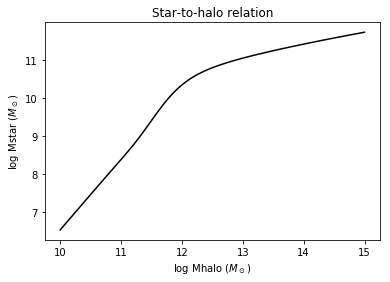

In [12]:
z0 = 0    
redshift = np.linspace (z0, 10, 100)
Mvir0 = (1e11, 1e12, 1e13, 1e14, 1e15)
Mstar = np.linspace(1e10, 1e12)
Mhalo = np.logspace(10, 15, 100)
Ms = SHMR(1, Mhalo)


fig, ax = plt.subplots() 
ax.plot(np.log10(Mhalo), np.log10(Ms), '-k')
plt.title('Star-to-halo relation')
#plt.plot(np.log10(Mhalo), np.log10(Ms), '-k')
plt.xlabel('log Mhalo ($M_\odot$)')
plt.ylabel('log Mstar ($M_\odot$)')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/Star_to_halo.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


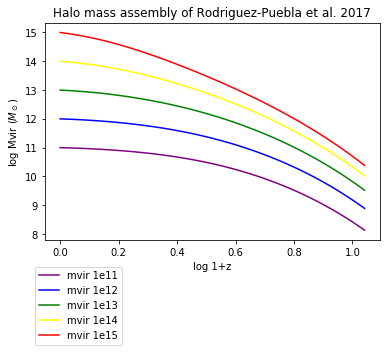

In [13]:
Mvirz = halo_mass_assembly(Mvir0[0], z0, redshift)
Mvirz2 = halo_mass_assembly(Mvir0[1], z0, redshift)
Mvirz3 = halo_mass_assembly(Mvir0[2], z0, redshift)
Mvirz4 = halo_mass_assembly(Mvir0[3], z0, redshift)
Mvirz5 = halo_mass_assembly(Mvir0[4], z0, redshift)

plt.title('Halo mass assembly of Rodriguez-Puebla et al. 2017')
plt.plot(np.log10(1+redshift), np.log10(Mvirz), color='purple', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Mvirz2), color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Mvirz3), color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Mvirz4), color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Mvirz5), color='red', label='mvir 1e15')

plt.xlabel('log 1+z')
plt.ylabel('log Mvir ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/halo_mass_assebly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


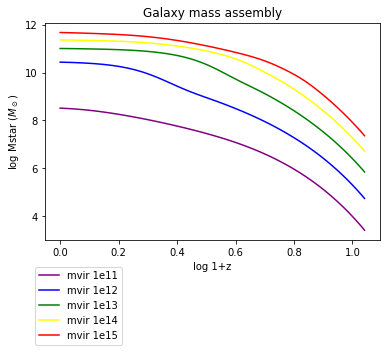

In [14]:
Ms_z = galaxy_mass_assembly(Mvir0[0], z0, redshift)
Ms_z2 = galaxy_mass_assembly(Mvir0[1], z0, redshift)
Ms_z3 = galaxy_mass_assembly(Mvir0[2], z0, redshift)
Ms_z4 = galaxy_mass_assembly(Mvir0[3], z0, redshift)
Ms_z5 = galaxy_mass_assembly(Mvir0[4], z0, redshift)

plt.title('Galaxy mass assembly')
plt.plot(np.log10(1+redshift), np.log10(Ms_z), color='purple', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Ms_z2), color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Ms_z3), color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Ms_z4), color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Ms_z5), color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log Mstar ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/galaxy_mass_assembly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


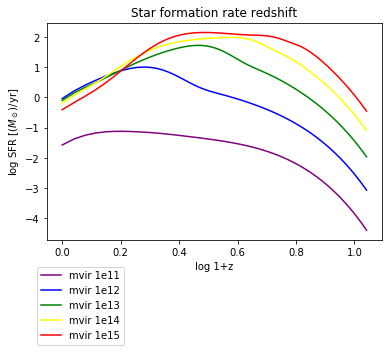

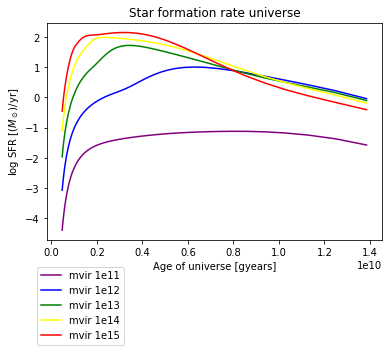

In [15]:
z = np.linspace (0, 10, 100)
dmdt1 = []
dmdt2 = []
dmdt3 = []
dmdt4 = []
dmdt5 = []
for i in range(0, 100):
    redshift = z[i]
    dmdt1.append(SFR(Mvir0[0],z0,redshift))
    dmdt2.append(SFR(Mvir0[1],z0,redshift))
    dmdt3.append(SFR(Mvir0[2],z0,redshift))
    dmdt4.append(SFR(Mvir0[3],z0,redshift))
    dmdt5.append(SFR(Mvir0[4],z0,redshift))

plt.title('Star formation rate redshift')
plt.plot(np.log10(1+z), np.log10(dmdt1), '-k', color='purple', label='mvir 1e11')
plt.plot(np.log10(1+z), np.log10(dmdt2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+z), np.log10(dmdt3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+z), np.log10(dmdt4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+z), np.log10(dmdt5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log SFR [($M_\odot$)/yr]')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/Star_formation_redshift.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()



plt.title('Star formation rate universe')
plt.plot(AgeUniverse(Om_mat_cero, Om_lambda_cero, h, z), np.log10(dmdt1), '-k', color='purple', label='mvir 1e11')
plt.plot(AgeUniverse(Om_mat_cero, Om_lambda_cero, h, z), np.log10(dmdt2), '-k', color='blue', label='mvir 1e12')
plt.plot(AgeUniverse(Om_mat_cero, Om_lambda_cero, h, z), np.log10(dmdt3), '-k', color='green', label='mvir 1e13')
plt.plot(AgeUniverse(Om_mat_cero, Om_lambda_cero, h, z), np.log10(dmdt4), '-k', color='yellow', label='mvir 1e14')
plt.plot(AgeUniverse(Om_mat_cero, Om_lambda_cero, h, z), np.log10(dmdt5), '-k', color='red', label='mvir 1e15')
plt.xlabel('Age of universe [gyears]')
plt.ylabel('log SFR [($M_\odot$)/yr]')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/Star_formation_universe.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


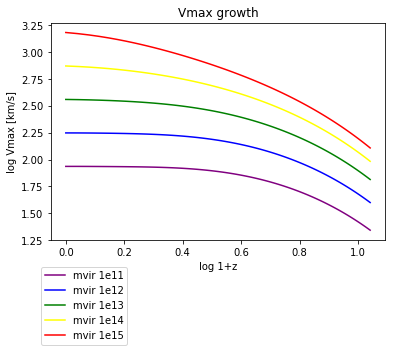

In [16]:
redshift = np.linspace (0, 10, 100)
Vmax1 = Vmax_assembly(Mvir0[0],z0, redshift)
Vmax2 = Vmax_assembly(Mvir0[1],z0, redshift)
Vmax3 = Vmax_assembly(Mvir0[2],z0, redshift)
Vmax4 = Vmax_assembly(Mvir0[3],z0, redshift)
Vmax5 = Vmax_assembly(Mvir0[4],z0, redshift)

plt.title('Vmax growth')
plt.plot(np.log10(1+redshift), np.log10(Vmax1), '-k', color='purple', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Vmax2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Vmax3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Vmax4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Vmax5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log Vmax [km/s]')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/Vmax_growth.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


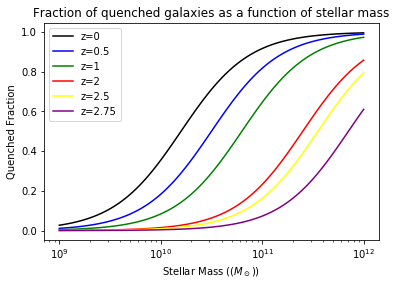

In [17]:
Mstar = np.logspace(9, 12, 100)
plt.title('Fraction of quenched galaxies as a function of stellar mass')
plt.semilogx(Mstar, fQ(Mstar,z0) ,'-', color='black', label='z=0')
plt.semilogx(Mstar, fQ(Mstar,0.5) ,'-', color='blue', label='z=0.5')
plt.semilogx(Mstar, fQ(Mstar,1) ,'-', color='green', label='z=1')
plt.semilogx(Mstar, fQ(Mstar,2) ,'-', color='red', label='z=2')
plt.semilogx(Mstar, fQ(Mstar,2.25) ,'-', color='yellow', label='z=2.5')
plt.semilogx(Mstar, fQ(Mstar,2.75) ,'-', color='purple', label='z=2.75')
plt.xlabel('Stellar Mass (($M_\odot$))')
plt.ylabel('Quenched Fraction')
plt.legend(loc='upper left')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/frac_quenched_stellar_mass.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


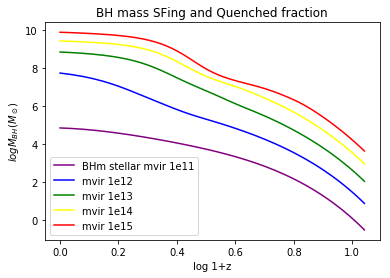

In [18]:
redshift = np.linspace (z0, 10, 100)
M_bh_mse1 = average_MBH_Ms_relation(Mvir0[0],z0, redshift)
M_bh_mse2 = average_MBH_Ms_relation(Mvir0[1],z0, redshift)
M_bh_mse3 = average_MBH_Ms_relation(Mvir0[2],z0, redshift)
M_bh_mse4 = average_MBH_Ms_relation(Mvir0[3],z0, redshift)
M_bh_mse5 = average_MBH_Ms_relation(Mvir0[4],z0, redshift)

plt.title('BH mass SFing and Quenched fraction')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse1), '-', color='purple', label='BHm stellar mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse2), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse3), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse4), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse5), '-', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('$log M_{BH} (M_\odot$)')
plt.legend(loc='lower left')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/BHmass_SFnQ.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


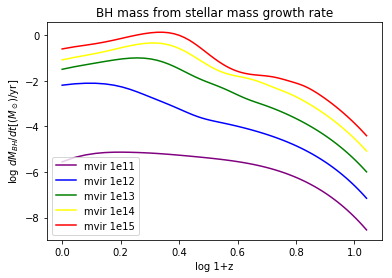

In [19]:
z = np.linspace (0, 10, 100)
dmbhdt1 = []
dmbhdt2 = []
dmbhdt3 = []
dmbhdt4 = []
dmbhdt5 = []
for i in range(0, 100):
    redshift = z[i]
    dmbhdt1.append(dMBH_dt(Mvir0[0],z0,redshift))
    dmbhdt2.append(dMBH_dt(Mvir0[1],z0,redshift))
    dmbhdt3.append(dMBH_dt(Mvir0[2],z0,redshift))
    dmbhdt4.append(dMBH_dt(Mvir0[3],z0,redshift))
    dmbhdt5.append(dMBH_dt(Mvir0[4],z0,redshift))

plt.title('BH mass from stellar mass growth rate')
plt.plot(np.log10(1+z), np.log10(dmbhdt1), '-k', color='purple', label='mvir 1e11')
plt.plot(np.log10(1+z), np.log10(dmbhdt2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+z), np.log10(dmbhdt3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+z), np.log10(dmbhdt4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+z), np.log10(dmbhdt5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log $d M_{BH}/dt [(M_\odot$)/yr]')
plt.legend(loc='lower left')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/BHmass_MsGrowth.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


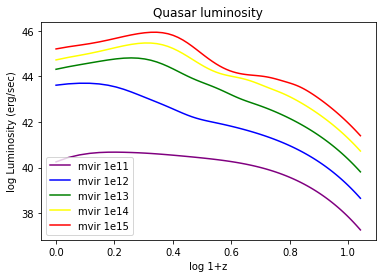

In [20]:
Lum_q_s1= []
Lum_q_s2= []
Lum_q_s3= []
Lum_q_s4= []
Lum_q_s5= []

for i in range(0, 100):
    redshift = z[i]
    Lum_q_s1.append(Lum_quasar(Mvir0[0], z0, redshift))
    Lum_q_s2.append(Lum_quasar(Mvir0[1], z0, redshift))
    Lum_q_s3.append(Lum_quasar(Mvir0[2], z0, redshift))
    Lum_q_s4.append(Lum_quasar(Mvir0[3], z0, redshift))
    Lum_q_s5.append(Lum_quasar(Mvir0[4], z0, redshift))


plt.title('Quasar luminosity')
plt.plot(np.log10(1+z), np.log10(Lum_q_s1), '-', color='purple', label='mvir 1e11')
plt.plot(np.log10(1+z), np.log10(Lum_q_s2), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+z), np.log10(Lum_q_s3), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+z), np.log10(Lum_q_s4), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+z), np.log10(Lum_q_s5), '-', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log Luminosity (erg/sec)')
plt.legend(loc='lower left')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/Quasar_lum.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


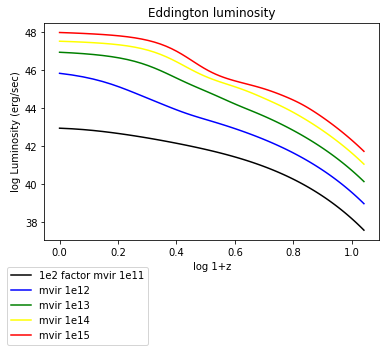

In [21]:
redshift = np.linspace (0, 10, 100)

Lum_ed1 = Lum_eddigton(Mvir0[0], z0, redshift)
Lum_ed2 = Lum_eddigton(Mvir0[1], z0, redshift)
Lum_ed3 = Lum_eddigton(Mvir0[2], z0, redshift)
Lum_ed4 = Lum_eddigton(Mvir0[3], z0, redshift)
Lum_ed5 = Lum_eddigton(Mvir0[4], z0, redshift)

plt.title('Eddington luminosity')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed1), '-', color='black', label='1e2 factor mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed2), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed3), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed4), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed5), '-', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log Luminosity (erg/sec)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/lum_edd.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

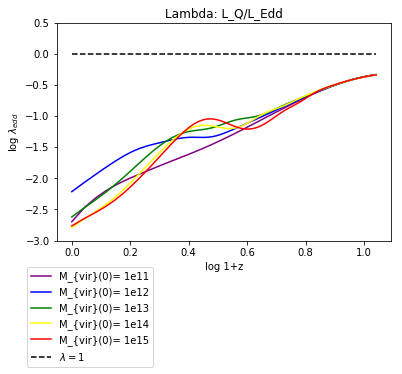

In [22]:
    
#Lum_ed1 = Lum_eddigton(Mvir0[0], z0, z)
#Lum_ed2 = Lum_eddigton(Mvir0[1], z0, z)
#Lum_ed3 = Lum_eddigton(Mvir0[2], z0, z)
#Lum_ed4 = Lum_eddigton(Mvir0[3], z0, z)
#Lum_ed5 = Lum_eddigton(Mvir0[4], z0, z)
z = np.linspace (0, 10, 100)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

y0 = z*0 

for i in range(0, 100):
        redshift = z[i]
        ratio1.append(Lum_quasar(Mvir0[0], z0, redshift)/ Lum_eddigton(Mvir0[0], z0, redshift))
        ratio2.append(Lum_quasar(Mvir0[1], z0, redshift)/ Lum_eddigton(Mvir0[1], z0, redshift))
        ratio3.append(Lum_quasar(Mvir0[2], z0, redshift)/ Lum_eddigton(Mvir0[2], z0, redshift))
        ratio4.append(Lum_quasar(Mvir0[3], z0, redshift)/ Lum_eddigton(Mvir0[3], z0, redshift))
        ratio5.append(Lum_quasar(Mvir0[4], z0, redshift)/ Lum_eddigton(Mvir0[4], z0, redshift))



plt.title('Lambda: L_Q/L_Edd')
plt.plot(np.log10(1+z), np.log10(ratio1), '-', color='purple', label='M_{vir}(0)= 1e11')
plt.plot(np.log10(1+z), np.log10(ratio2), '-', color='blue', label='M_{vir}(0)= 1e12')
plt.plot(np.log10(1+z), np.log10(ratio3), '-', color='green', label='M_{vir}(0)= 1e13')
plt.plot(np.log10(1+z), np.log10(ratio4), '-', color='yellow', label='M_{vir}(0)= 1e14')
plt.plot(np.log10(1+z), np.log10(ratio5), '-', color='red', label='M_{vir}(0)= 1e15')
plt.plot(np.log10(1+z), y0, '--', color='black', label='$\lambda = 1$')
plt.xlabel('log 1+z')
plt.ylabel('log $\lambda_{edd}$')
plt.ylim(-3,0.5)
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/lambda.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show() 

    

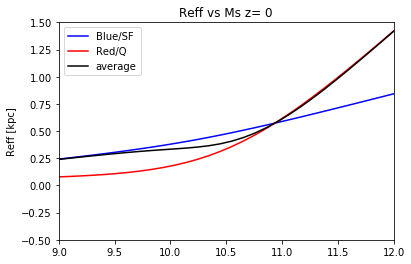

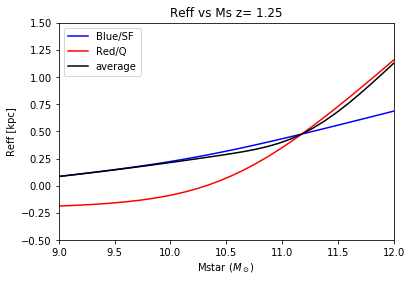

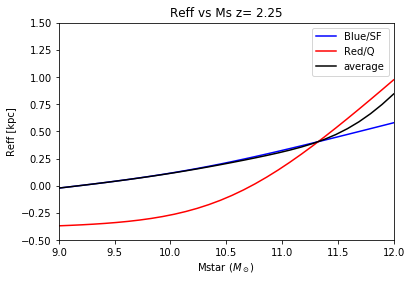

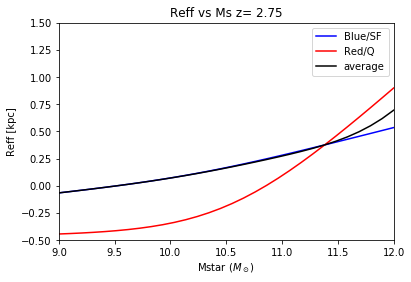

In [23]:
z= 0
Ms = np.logspace(9, 12, 30)
reff_sf = Reff_sf(Ms, z)
reff_q = Reff_Q(Ms, z)
reff_all = []
for i in range(0, 30):
    m_s = Ms[i]
    reff_all.append(avg_rad_eff(m_s, z))
    

plt.title('Reff vs Ms z= 0')
plt.plot(np.log10(Ms), np.log10(reff_sf), '-', color='blue', label='Blue/SF')
plt.plot(np.log10(Ms), np.log10(reff_q), '-', color='red', label='Red/Q')
plt.plot(np.log10(Ms), np.log10(reff_all), '-', color='black', label='average')
#plt.xlabel('Mstar ($M_\odot$)')
plt.ylabel('Reff [kpc]')
plt.xlim(9, 12)
plt.ylim(-0.5,1.5)
plt.legend()
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/Reff_vsMs_z0.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()



z= 1.25
Ms = np.logspace(9, 12, 30)
reff_sf = Reff_sf(Ms, z)
reff_q = Reff_Q(Ms, z)
reff_all = []
for i in range(0, 30):
    m_s = Ms[i]
    reff_all.append(avg_rad_eff(m_s, z))

plt.title('Reff vs Ms z= 1.25')
plt.plot(np.log10(Ms), np.log10(reff_sf), '-', color='blue', label='Blue/SF')
plt.plot(np.log10(Ms), np.log10(reff_q), '-', color='red', label='Red/Q')
plt.plot(np.log10(Ms), np.log10(reff_all), '-', color='black', label='average')
plt.xlabel('Mstar ($M_\odot$)')
plt.ylabel('Reff [kpc]')
plt.xlim(9, 12)
plt.ylim(-0.5,1.5)
plt.legend()
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/Reff_vsMs_z125.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


z= 2.25
Ms = np.logspace(9, 12, 30)
reff_sf = Reff_sf(Ms, z)
reff_q = Reff_Q(Ms, z)
reff_all = []
for i in range(0, 30):
    m_s = Ms[i]
    reff_all.append(avg_rad_eff(m_s, z))

plt.title('Reff vs Ms z= 2.25')
plt.plot(np.log10(Ms), np.log10(reff_sf), '-', color='blue', label='Blue/SF')
plt.plot(np.log10(Ms), np.log10(reff_q), '-', color='red', label='Red/Q')
plt.plot(np.log10(Ms), np.log10(reff_all), '-', color='black', label='average')
plt.xlabel('Mstar ($M_\odot$)')
plt.ylabel('Reff [kpc]')
plt.xlim(9, 12)
plt.ylim(-0.5,1.5)
plt.legend()
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/Reff_vsMs_z225.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


z= 2.75
Ms = np.logspace(9, 12, 30)
reff_sf = Reff_sf(Ms, z)
reff_q = Reff_Q(Ms, z)
reff_all = []
for i in range(0, 30):
    m_s = Ms[i]
    reff_all.append(avg_rad_eff(m_s, z))

plt.title('Reff vs Ms z= 2.75')
plt.plot(np.log10(Ms), np.log10(reff_sf), '-', color='blue', label='Blue/SF')
plt.plot(np.log10(Ms), np.log10(reff_q), '-', color='red', label='Red/Q')
plt.plot(np.log10(Ms), np.log10(reff_all), '-', color='black', label='average')
plt.xlabel('Mstar ($M_\odot$)')
plt.ylabel('Reff [kpc]')
plt.xlim(9, 12)
plt.ylim(-0.5,1.5)
plt.legend()
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/Reff_vsMs_z275.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


[1.00000000e-02 1.16226758e-02 1.35086592e-02 1.57006766e-02
 1.82483873e-02 2.12095089e-02 2.46511245e-02 2.86512027e-02
 3.33003639e-02 3.87039333e-02 4.49843267e-02 5.22838243e-02
 6.07677938e-02 7.06284364e-02 8.20891416e-02 9.54095476e-02
 1.10891424e-01 1.28885506e-01 1.49799445e-01 1.74107038e-01
 2.02358965e-01 2.35195264e-01 2.73359829e-01 3.17717266e-01
 3.69272476e-01 4.29193426e-01 4.98837603e-01 5.79782772e-01
 6.73862717e-01 7.83208787e-01 9.10298178e-01 1.05801006e+00
 1.22969078e+00 1.42922973e+00 1.66114737e+00 1.93069773e+00
 2.24398737e+00 2.60811376e+00 3.03132606e+00 3.52321199e+00
 4.09491506e+00 4.75938700e+00 5.53168120e+00 6.42929370e+00
 7.47255960e+00 8.68511374e+00 1.00944261e+01 1.17324241e+01
 1.36362162e+01 1.58489319e+01]


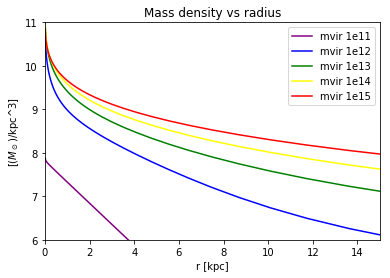

In [24]:
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)
z= 0.1
Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])
r= np.logspace(-2, 1.2, 50)
print(r)
mass_den1 = mass_density_avg(Ms1, z, r)
mass_den2 = mass_density_avg(Ms2, z, r)
mass_den3 = mass_density_avg(Ms3, z, r)
mass_den4 = mass_density_avg(Ms4, z, r)
mass_den5 = mass_density_avg(Ms5, z, r)

plt.title('Mass density vs radius')
plt.plot(r, np.log10(mass_den1), '-k', color='purple', label='mvir 1e11')
plt.plot(r, np.log10(mass_den2), '-k', color='blue', label='mvir 1e12')
plt.plot(r, np.log10(mass_den3), '-k', color='green', label='mvir 1e13')
plt.plot(r, np.log10(mass_den4), '-k', color='yellow', label='mvir 1e14')
plt.plot(r, np.log10(mass_den5), '-k', color='red', label='mvir 1e15')

plt.xlabel('r [kpc]')
plt.ylabel('[($M_\odot$)/kpc^3]')
plt.xlim(0, 15)
plt.ylim(6, 11)
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MassDen_vs_rad.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

8.51580707421677 10.434716911551003 11.004707666112377 11.364470329285522 11.672246259140458


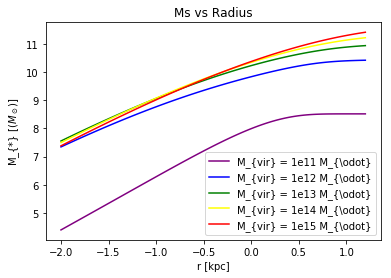

In [25]:
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)
z= 0
Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])
print(np.log10(Ms1),np.log10(Ms2),np.log10(Ms3),np.log10(Ms4),np.log10(Ms5))
mass_p1 = []
mass_p2 = []
mass_p3 = []
mass_p4 = []
mass_p5 = []

radius = np.logspace(-2, 1.2, 100)
for i in range(0, 100):
    r = radius[i]
    mass_p1.append(mass_profile(r, Ms1, z))
    mass_p2.append(mass_profile(r, Ms2, z))
    mass_p3.append(mass_profile(r, Ms3, z))
    mass_p4.append(mass_profile(r, Ms4, z))
    mass_p5.append(mass_profile(r, Ms5, z))


plt.title('Ms vs Radius')
plt.plot(np.log10(radius), np.log10(mass_p1), '-k', color='purple', label='M_{vir} = 1e11 M_{\odot}')
plt.plot(np.log10(radius), np.log10(mass_p2), '-k', color='blue', label='M_{vir} = 1e12 M_{\odot}')
plt.plot(np.log10(radius), np.log10(mass_p3), '-k', color='green', label='M_{vir} = 1e13 M_{\odot}')
plt.plot(np.log10(radius), np.log10(mass_p4), '-k', color='yellow', label='M_{vir} = 1e14 M_{\odot}')
plt.plot(np.log10(radius), np.log10(mass_p5), '-k', color='red', label='M_{vir} = 1e15 M_{\odot}')

plt.xlabel('r [kpc]')
plt.ylabel('M_{*} [($M_\odot$)]')
plt.legend(loc='lower right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/Ms_vs_Radius.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

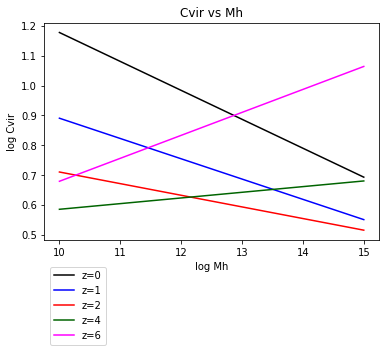

In [26]:
cvir1 = []
cvir2 = []
cvir3 = []
cvir4 = []
cvir5 = []
redshift = [0,1,2,4,6]
Mh = np.logspace(10, 15, 100)
Mhalo = np.logspace(10, 15, 100)
for i in range(0,100):
    m_h = Mhalo[i]
    cvir1.append(c_vir(m_h, redshift[0], h))
    cvir2.append(c_vir(m_h, redshift[1], h))
    cvir3.append(c_vir(m_h, redshift[2], h))
    cvir4.append(c_vir(m_h, redshift[3], h))
    cvir5.append(c_vir(m_h, redshift[4], h))
    
plt.title('Cvir vs Mh')
plt.plot(np.log10(Mh), np.log10(cvir1), '-k', color='black', label='z=0')
plt.plot(np.log10(Mh), np.log10(cvir2), '-k', color='blue', label='z=1')
plt.plot(np.log10(Mh), np.log10(cvir3), '-k', color='red', label='z=2')
plt.plot(np.log10(Mh), np.log10(cvir4), '-k', color='darkgreen', label='z=4')
plt.plot(np.log10(Mh), np.log10(cvir5), '-k', color='magenta', label='z=6')
plt.xlabel('log Mh')
plt.ylabel('log Cvir')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/Cvir_Vs_Mh.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


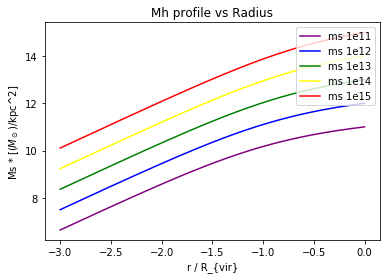

In [27]:
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)
z0 = 0 

mh_p1 = []
mh_p2 = []
mh_p3 = []
mh_p4 = []
mh_p5 = []

Rvir1 = r_vir(Mvir[0], Om_mat_cero, Om_lambda_cero, z0)
Rvir2 = r_vir(Mvir[1], Om_mat_cero, Om_lambda_cero, z0)
Rvir3 = r_vir(Mvir[2], Om_mat_cero, Om_lambda_cero, z0)
Rvir4 = r_vir(Mvir[3], Om_mat_cero, Om_lambda_cero, z0)
Rvir5 = r_vir(Mvir[4], Om_mat_cero, Om_lambda_cero, z0)


radius = np.linspace(-3, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    mh_p1.append(M_h_profile(Mvir[0], Rvir1 * r,  Om_mat_cero, Om_lambda_cero, z0, h))
    mh_p2.append(M_h_profile(Mvir[1], Rvir2 * r,  Om_mat_cero, Om_lambda_cero, z0, h))
    mh_p3.append(M_h_profile(Mvir[2], Rvir3 * r,  Om_mat_cero, Om_lambda_cero, z0, h))
    mh_p4.append(M_h_profile(Mvir[3], Rvir4 * r,  Om_mat_cero, Om_lambda_cero, z0, h))
    mh_p5.append(M_h_profile(Mvir[4], Rvir5 * r,  Om_mat_cero, Om_lambda_cero, z0, h))
    
plt.title('Mh profile vs Radius')
plt.plot(radius, np.log10(mh_p1), '-k', color='purple', label='ms 1e11')
plt.plot(radius, np.log10(mh_p2), '-k', color='blue', label='ms 1e12')
plt.plot(radius, np.log10(mh_p3), '-k', color='green', label='ms 1e13')
plt.plot(radius, np.log10(mh_p4), '-k', color='yellow', label='ms 1e14')
plt.plot(radius, np.log10(mh_p5), '-k', color='red', label='ms 1e15')

plt.xlabel('r / R_{vir}')
plt.ylabel('Ms * [($M_\odot$)/kpc^2]')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MHprof_vs_rad.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()




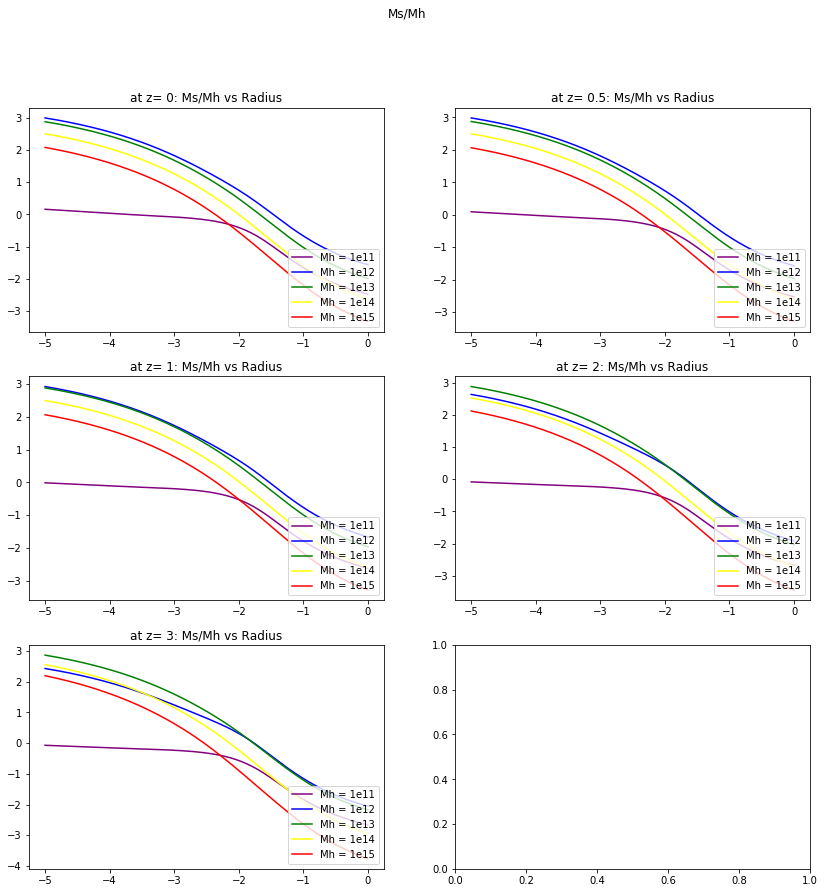

In [30]:
z=0
z0= 0
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)
Rvir1 = r_vir(Mvir[0], Om_mat_cero, Om_lambda_cero, z0)
Rvir2 = r_vir(Mvir[1], Om_mat_cero, Om_lambda_cero, z0)
Rvir3 = r_vir(Mvir[2], Om_mat_cero, Om_lambda_cero, z0)
Rvir4 = r_vir(Mvir[3], Om_mat_cero, Om_lambda_cero, z0)
Rvir5 = r_vir(Mvir[4], Om_mat_cero, Om_lambda_cero, z0)

Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio1.append(mass_profile(r1, Ms1, z0)/M_h_profile(Mvir[0], r1,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio2.append(mass_profile(r2, Ms2, z0)/M_h_profile(Mvir[1], r2,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio3.append(mass_profile(r3, Ms3, z0)/M_h_profile(Mvir[2], r3,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio4.append(mass_profile(r4, Ms4, z0)/M_h_profile(Mvir[3], r4,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio5.append(mass_profile(r5, Ms5, z0)/M_h_profile(Mvir[4], r5,  Om_mat_cero, Om_lambda_cero, z0, h))

#plt.title('at z= 0: Ms/Mh vs Radius')
#plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='Mh = 1e11')
#plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='Mh = 1e12')
#plt.plot(radius, np.log10(ratio3), '-k', color='green', label='Mh = 1e13')
#plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='Mh = 1e14')
#plt.plot(radius, np.log10(ratio5), '-k', color='red', label='Mh = 1e15')

#plt.xlabel('log10 r/Rvir')
#plt.ylabel('log10 $M_*/M_{vir} (r)$')
#plt.legend(loc='upper right')
#kl;,plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh_vs_radius.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
#plt.show()

z1= 0.5
z0= 0
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)
Rvir1 = r_vir(Mvir[0], Om_mat_cero, Om_lambda_cero, z0)
Rvir2 = r_vir(Mvir[1], Om_mat_cero, Om_lambda_cero, z0)
Rvir3 = r_vir(Mvir[2], Om_mat_cero, Om_lambda_cero, z0)
Rvir4 = r_vir(Mvir[3], Om_mat_cero, Om_lambda_cero, z0)
Rvir5 = r_vir(Mvir[4], Om_mat_cero, Om_lambda_cero, z0)

Ms11 = SHMR(z1,Mvir[0])
Ms21 = SHMR(z1,Mvir[1])
Ms31 = SHMR(z1,Mvir[2])
Ms41 = SHMR(z1,Mvir[3])
Ms51 = SHMR(z1,Mvir[4])


ratio11=[]
ratio21=[]
ratio31=[]
ratio41=[]
ratio51=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio11.append(mass_profile(r1, Ms11, z0)/M_h_profile(Mvir[0], r1,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio21.append(mass_profile(r2, Ms21, z0)/M_h_profile(Mvir[1], r2,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio31.append(mass_profile(r3, Ms31, z0)/M_h_profile(Mvir[2], r3,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio41.append(mass_profile(r4, Ms41, z0)/M_h_profile(Mvir[3], r4,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio51.append(mass_profile(r5, Ms51, z0)/M_h_profile(Mvir[4], r5,  Om_mat_cero, Om_lambda_cero, z0, h))

#plt.title('at z= 0.5: Ms/Mh vs Radius')
#plt.plot(radius, np.log10(ratio11), '-k', color='purple', label='Mh = 1e11')
#plt.plot(radius, np.log10(ratio21), '-k', color='blue', label='Mh = 1e12')
#plt.plot(radius, np.log10(ratio31), '-k', color='green', label='Mh = 1e13')
#plt.plot(radius, np.log10(ratio41), '-k', color='yellow', label='Mh = 1e14')
#plt.plot(radius, np.log10(ratio51), '-k', color='red', label='Mh = 1e15')

#plt.xlabel('log10 r/Rvir')
#plt.ylabel('log10 $M_*/M_{vir} (r)$')
#plt.legend(loc='upper right')
#plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh_vs_radius_z05.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
#plt.show()


z2= 1
z0= 0
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)
Rvir1 = r_vir(Mvir[0], Om_mat_cero, Om_lambda_cero, z0)
Rvir2 = r_vir(Mvir[1], Om_mat_cero, Om_lambda_cero, z0)
Rvir3 = r_vir(Mvir[2], Om_mat_cero, Om_lambda_cero, z0)
Rvir4 = r_vir(Mvir[3], Om_mat_cero, Om_lambda_cero, z0)
Rvir5 = r_vir(Mvir[4], Om_mat_cero, Om_lambda_cero, z0)

Ms12 = SHMR(z2,Mvir[0])
Ms22 = SHMR(z2,Mvir[1])
Ms32 = SHMR(z2,Mvir[2])
Ms42 = SHMR(z2,Mvir[3])
Ms52 = SHMR(z2,Mvir[4])

ratio12=[]
ratio22=[]
ratio32=[]
ratio42=[]
ratio52=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio12.append(mass_profile(r1, Ms12, z0)/M_h_profile(Mvir[0], r1,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio22.append(mass_profile(r2, Ms22, z0)/M_h_profile(Mvir[1], r2,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio32.append(mass_profile(r3, Ms32, z0)/M_h_profile(Mvir[2], r3,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio42.append(mass_profile(r4, Ms42, z0)/M_h_profile(Mvir[3], r4,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio52.append(mass_profile(r5, Ms52, z0)/M_h_profile(Mvir[4], r5,  Om_mat_cero, Om_lambda_cero, z0, h))

#plt.title('at z= 1: Ms/Mh vs Radius')
#plt.plot(radius, np.log10(ratio12), '-k', color='purple', label='Mh = 1e11')
#plt.plot(radius, np.log10(ratio22), '-k', color='blue', label='Mh = 1e12')
#plt.plot(radius, np.log10(ratio32), '-k', color='green', label='Mh = 1e13')
#plt.plot(radius, np.log10(ratio42), '-k', color='yellow', label='Mh = 1e14')
#plt.plot(radius, np.log10(ratio52), '-k', color='red', label='Mh = 1e15')

#plt.xlabel('log10 r/Rvir')
#plt.ylabel('log10 $M_*/M_{vir} (r)$')
#plt.legend(loc='upper right')
#plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh_vs_radius_z1.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
#plt.show()


z3= 2
z0= 0
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)
Rvir1 = r_vir(Mvir[0], Om_mat_cero, Om_lambda_cero, z0)
Rvir2 = r_vir(Mvir[1], Om_mat_cero, Om_lambda_cero, z0)
Rvir3 = r_vir(Mvir[2], Om_mat_cero, Om_lambda_cero, z0)
Rvir4 = r_vir(Mvir[3], Om_mat_cero, Om_lambda_cero, z0)
Rvir5 = r_vir(Mvir[4], Om_mat_cero, Om_lambda_cero, z0)

Ms13 = SHMR(z3,Mvir[0])
Ms23 = SHMR(z3,Mvir[1])
Ms33 = SHMR(z3,Mvir[2])
Ms43 = SHMR(z3,Mvir[3])
Ms53 = SHMR(z3,Mvir[4])

ratio13=[]
ratio23=[]
ratio33=[]
ratio43=[]
ratio53=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio13.append(mass_profile(r1, Ms13, z0)/M_h_profile(Mvir[0], r1,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio23.append(mass_profile(r2, Ms23, z0)/M_h_profile(Mvir[1], r2,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio33.append(mass_profile(r3, Ms33, z0)/M_h_profile(Mvir[2], r3,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio43.append(mass_profile(r4, Ms43, z0)/M_h_profile(Mvir[3], r4,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio53.append(mass_profile(r5, Ms53, z0)/M_h_profile(Mvir[4], r5,  Om_mat_cero, Om_lambda_cero, z0, h))

#plt.title('at z= 2: Ms/Mh vs Radius')
#plt.plot(radius, np.log10(ratio13), '-k', color='purple', label='Mh = 1e11')
#plt.plot(radius, np.log10(ratio23), '-k', color='blue', label='Mh = 1e12')
#plt.plot(radius, np.log10(ratio33), '-k', color='green', label='Mh = 1e13')
#plt.plot(radius, np.log10(ratio43), '-k', color='yellow', label='Mh = 1e14')
#plt.plot(radius, np.log10(ratio53), '-k', color='red', label='Mh = 1e15')

#plt.xlabel('log10 r/Rvir')
#plt.ylabel('log10 $M_*/M_{vir} (r)$')
#plt.legend(loc='upper right')
#plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh_vs_radius_z2.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
#plt.show()


z4= 3
z0= 0
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)
Rvir1 = r_vir(Mvir[0], Om_mat_cero, Om_lambda_cero, z0)
Rvir2 = r_vir(Mvir[1], Om_mat_cero, Om_lambda_cero, z0)
Rvir3 = r_vir(Mvir[2], Om_mat_cero, Om_lambda_cero, z0)
Rvir4 = r_vir(Mvir[3], Om_mat_cero, Om_lambda_cero, z0)
Rvir5 = r_vir(Mvir[4], Om_mat_cero, Om_lambda_cero, z0)

Ms14 = SHMR(z4,Mvir[0])
Ms24 = SHMR(z4,Mvir[1])
Ms34 = SHMR(z4,Mvir[2])
Ms44 = SHMR(z4,Mvir[3])
Ms54 = SHMR(z4,Mvir[4])

ratio14=[]
ratio24=[]
ratio34=[]
ratio44=[]
ratio54=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio14.append(mass_profile(r1, Ms14, z0)/M_h_profile(Mvir[0], r1,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio24.append(mass_profile(r2, Ms24, z0)/M_h_profile(Mvir[1], r2,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio34.append(mass_profile(r3, Ms34, z0)/M_h_profile(Mvir[2], r3,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio44.append(mass_profile(r4, Ms44, z0)/M_h_profile(Mvir[3], r4,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio54.append(mass_profile(r5, Ms54, z0)/M_h_profile(Mvir[4], r5,  Om_mat_cero, Om_lambda_cero, z0, h))

#plt.title('at z= 3: Ms/Mh vs Radius')
#plt.plot(radius, np.log10(ratio14), '-k', color='purple', label='Mh = 1e11')
#plt.plot(radius, np.log10(ratio24), '-k', color='blue', label='Mh = 1e12')
#plt.plot(radius, np.log10(ratio34), '-k', color='green', label='Mh = 1e13')
#plt.plot(radius, np.log10(ratio44), '-k', color='yellow', label='Mh = 1e14')
#plt.plot(radius, np.log10(ratio54), '-k', color='red', label='Mh = 1e15')

#plt.xlabel('log10 r/Rvir')
#plt.ylabel('log10 $M_*/M_{vir} (r)$')
#plt.legend(loc='upper right')
#plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh_vs_radius_z3.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
#plt.show()




fig, ax = plt.subplots(3, 2, figsize=(14, 14))
fig.suptitle('Ms/Mh')

ax[0][0].set_title('at z= 0: Ms/Mh vs Radius')
ax[0][0].plot(radius, np.log10(ratio1), '-k', color='purple', label='Mh = 1e11')
ax[0][0].plot(radius, np.log10(ratio2), '-k', color='blue', label='Mh = 1e12')
ax[0][0].plot(radius, np.log10(ratio3), '-k', color='green', label='Mh = 1e13')
ax[0][0].plot(radius, np.log10(ratio4), '-k', color='yellow', label='Mh = 1e14')
ax[0][0].plot(radius, np.log10(ratio5), '-k', color='red', label='Mh = 1e15')

#ax[0][0].set_xlabel('log10 r/Rvir')
#ax[0][0].set_ylabel('log10 $M_*/M_{vir} (r)$')
ax[0][0].legend(loc='lower right')

ax[0][1].set_title('at z= 0.5: Ms/Mh vs Radius')
ax[0][1].plot(radius, np.log10(ratio11), '-k', color='purple', label='Mh = 1e11')
ax[0][1].plot(radius, np.log10(ratio21), '-k', color='blue', label='Mh = 1e12')
ax[0][1].plot(radius, np.log10(ratio31), '-k', color='green', label='Mh = 1e13')
ax[0][1].plot(radius, np.log10(ratio41), '-k', color='yellow', label='Mh = 1e14')
ax[0][1].plot(radius, np.log10(ratio51), '-k', color='red', label='Mh = 1e15')

#ax[0][1].set_xlabel('log10 r/Rvir')
#ax[0][1].set_ylabel('log10 $M_*/M_{vir} (r)$')
ax[0][1].legend(loc='lower right')

ax[1][0].set_title('at z= 1: Ms/Mh vs Radius')
ax[1][0].plot(radius, np.log10(ratio12), '-k', color='purple', label='Mh = 1e11')
ax[1][0].plot(radius, np.log10(ratio22), '-k', color='blue', label='Mh = 1e12')
ax[1][0].plot(radius, np.log10(ratio32), '-k', color='green', label='Mh = 1e13')
ax[1][0].plot(radius, np.log10(ratio42), '-k', color='yellow', label='Mh = 1e14')
ax[1][0].plot(radius, np.log10(ratio52), '-k', color='red', label='Mh = 1e15')

#ax[1][0].set_xlabel('log10 r/Rvir')
#ax[1][0].set_ylabel('log10 $M_*/M_{vir} (r)$')
ax[1][0].legend(loc='lower right')

ax[1][1].set_title('at z= 2: Ms/Mh vs Radius')
ax[1][1].plot(radius, np.log10(ratio13), '-k', color='purple', label='Mh = 1e11')
ax[1][1].plot(radius, np.log10(ratio23), '-k', color='blue', label='Mh = 1e12')
ax[1][1].plot(radius, np.log10(ratio33), '-k', color='green', label='Mh = 1e13')
ax[1][1].plot(radius, np.log10(ratio43), '-k', color='yellow', label='Mh = 1e14')
ax[1][1].plot(radius, np.log10(ratio53), '-k', color='red', label='Mh = 1e15')

#ax[1][1].set_xlabel('log10 r/Rvir')
#ax[1][1].set_ylabel('log10 $M_*/M_{vir} (r)$')
ax[1][1].legend(loc='lower right')


ax[2][0].set_title('at z= 3: Ms/Mh vs Radius')
ax[2][0].plot(radius, np.log10(ratio14), '-k', color='purple', label='Mh = 1e11')
ax[2][0].plot(radius, np.log10(ratio24), '-k', color='blue', label='Mh = 1e12')
ax[2][0].plot(radius, np.log10(ratio34), '-k', color='green', label='Mh = 1e13')
ax[2][0].plot(radius, np.log10(ratio44), '-k', color='yellow', label='Mh = 1e14')
ax[2][0].plot(radius, np.log10(ratio54), '-k', color='red', label='Mh = 1e15')

#ax[2][0].set_xlabel('log10 r/Rvir')
#ax[2][0].set_ylabel('log10 $M_*/M_{vir} (r)$')
ax[2][0].legend(loc='lower right')

plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/ms_mh_ratios_z.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


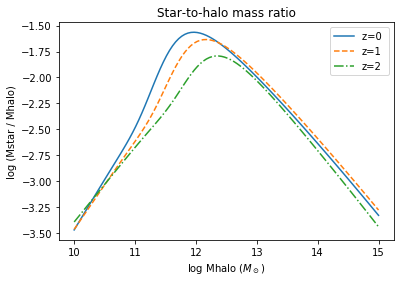

In [29]:

Mhalo = np.logspace(10, 15, 100)
Ms = SHMR(0, Mhalo)
Ms1 = SHMR(1., Mhalo)
Ms2 = SHMR(2., Mhalo)

plt.title('Star-to-halo mass ratio')
plt.plot(np.log10(Mhalo), np.log10(Ms/Mhalo), '-', label='z=0 ' )
plt.plot(np.log10(Mhalo), np.log10(Ms1/Mhalo), '--', label='z=1')
plt.plot(np.log10(Mhalo), np.log10(Ms2/Mhalo), '-.', label='z=2')
plt.xlabel('log Mhalo ($M_\odot$)')
plt.ylabel('log (Mstar / Mhalo)')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh_vs_Mh.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

#print(SHMR(0, 1e11)/1e11)
#print(SHMR(0, 1e12)/1e12)
#print(SHMR(0, 1e13)/1e13)
#print(SHMR(0, 1e14)/1e14)
#print(SHMR(0, 1e15)/1e15)

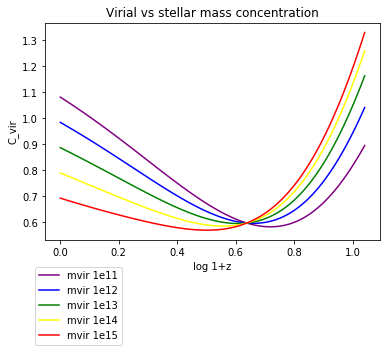

In [30]:
z = 0
z0 = 0
redshift = np.linspace(z0, 10, 100)
Mvir0 = [1e11,1e12,1e13,1e14,1e15,]

Mvh1 = halo_mass_assembly(Mvir0[0], z0, redshift)
Mvh2 = halo_mass_assembly(Mvir0[1], z0, redshift)
Mvh3 = halo_mass_assembly(Mvir0[2], z0, redshift)
Mvh4 = halo_mass_assembly(Mvir0[3], z0, redshift)
Mvh5 = halo_mass_assembly(Mvir0[4], z0, redshift)

Cvirz1 = c_vir(Mvh1, redshift, h)
Cvirz2 = c_vir(Mvh2, redshift, h)
Cvirz3 = c_vir(Mvh3, redshift, h)
Cvirz4 = c_vir(Mvh4, redshift, h)
Cvirz5 = c_vir(Mvh5, redshift, h)

plt.title('Virial vs stellar mass concentration')
plt.plot(np.log10(1+redshift), np.log10(Cvirz1), color='purple', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Cvirz2), color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Cvirz3), color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Cvirz4), color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Cvirz5), color='red', label='mvir 1e15')

plt.xlabel('log 1+z')
plt.ylabel('C_vir')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/vir_vs_ms_con.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

#################################################

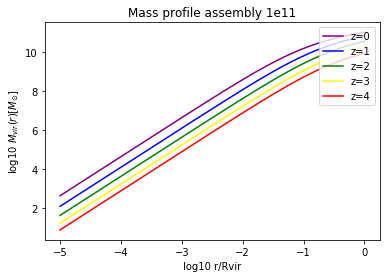

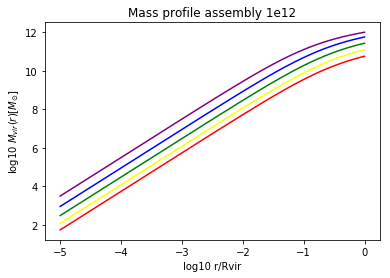

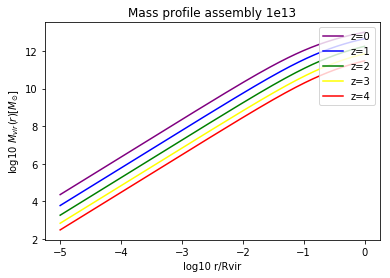

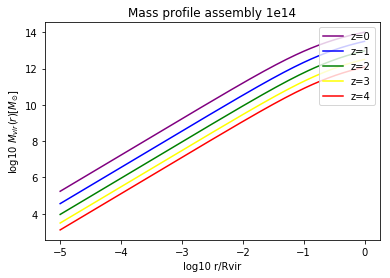

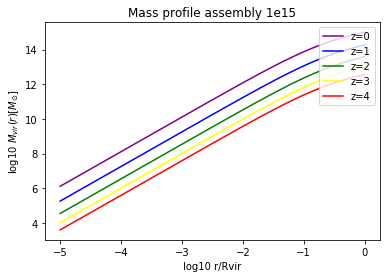

In [31]:
Mvh1 = halo_mass_assembly(Mvir0[0], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[0], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[0], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[0], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[0], z0, 4.)

Rvir1 = r_vir(Mvh1, Om_mat_cero, Om_lambda_cero, 0.)
Rvir2 = r_vir(Mvh2, Om_mat_cero, Om_lambda_cero, 1.)
Rvir3 = r_vir(Mvh3, Om_mat_cero, Om_lambda_cero, 2.)
Rvir4 = r_vir(Mvh4, Om_mat_cero, Om_lambda_cero, 3.)
Rvir5 = r_vir(Mvh5, Om_mat_cero, Om_lambda_cero, 4.)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio1.append(M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Mass profile assembly 1e11')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Rvir')
plt.ylabel('log10 $M_{vir} (r) [M_{\odot}]$')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/mass_prof_assm_11.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

##############################################################################

Mvh1 = halo_mass_assembly(Mvir0[1], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[1], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[1], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[1], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[1], z0, 4.)

Rvir1 = r_vir(Mvh1, Om_mat_cero, Om_lambda_cero, 0.)
Rvir2 = r_vir(Mvh2, Om_mat_cero, Om_lambda_cero, 1.)
Rvir3 = r_vir(Mvh3, Om_mat_cero, Om_lambda_cero, 2.)
Rvir4 = r_vir(Mvh4, Om_mat_cero, Om_lambda_cero, 3.)
Rvir5 = r_vir(Mvh5, Om_mat_cero, Om_lambda_cero, 4.)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio1.append(M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Mass profile assembly 1e12')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Rvir')
plt.ylabel('log10 $M_{vir} (r) [M_{\odot}]$')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/mass_prof_assm_12.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

##############################################################################

Mvh1 = halo_mass_assembly(Mvir0[2], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[2], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[2], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[2], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[2], z0, 4.)

Rvir1 = r_vir(Mvh1, Om_mat_cero, Om_lambda_cero, 0.)
Rvir2 = r_vir(Mvh2, Om_mat_cero, Om_lambda_cero, 1.)
Rvir3 = r_vir(Mvh3, Om_mat_cero, Om_lambda_cero, 2.)
Rvir4 = r_vir(Mvh4, Om_mat_cero, Om_lambda_cero, 3.)
Rvir5 = r_vir(Mvh5, Om_mat_cero, Om_lambda_cero, 4.)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio1.append(M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Mass profile assembly 1e13')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Rvir')
plt.ylabel('log10 $M_{vir} (r) [M_{\odot}]$')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/mass_prof_assm_13.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()
##############################################################################

Mvh1 = halo_mass_assembly(Mvir0[3], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[3], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[3], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[3], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[3], z0, 4.)

Rvir1 = r_vir(Mvh1, Om_mat_cero, Om_lambda_cero, 0.)
Rvir2 = r_vir(Mvh2, Om_mat_cero, Om_lambda_cero, 1.)
Rvir3 = r_vir(Mvh3, Om_mat_cero, Om_lambda_cero, 2.)
Rvir4 = r_vir(Mvh4, Om_mat_cero, Om_lambda_cero, 3.)
Rvir5 = r_vir(Mvh5, Om_mat_cero, Om_lambda_cero, 4.)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio1.append(M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Mass profile assembly 1e14')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Rvir')
plt.ylabel('log10 $M_{vir} (r) [M_{\odot}]$')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/mass_prof_assm_14.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()
##############################################################################

Mvh1 = halo_mass_assembly(Mvir0[4], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[4], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[4], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[4], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[4], z0, 4.)

Rvir1 = r_vir(Mvh1, Om_mat_cero, Om_lambda_cero, 0.)
Rvir2 = r_vir(Mvh2, Om_mat_cero, Om_lambda_cero, 1.)
Rvir3 = r_vir(Mvh3, Om_mat_cero, Om_lambda_cero, 2.)
Rvir4 = r_vir(Mvh4, Om_mat_cero, Om_lambda_cero, 3.)
Rvir5 = r_vir(Mvh5, Om_mat_cero, Om_lambda_cero, 4.)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio1.append(M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Mass profile assembly 1e15')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Rvir')
plt.ylabel('log10 $M_{vir} (r) [M_{\odot}]$')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/mass_prof_assm_15.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

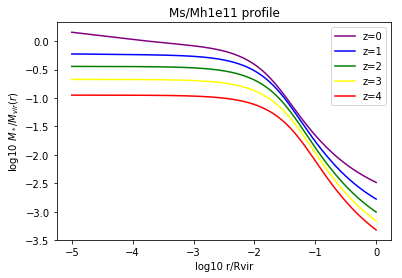

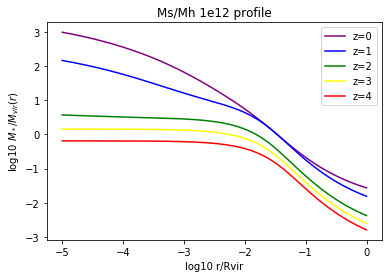

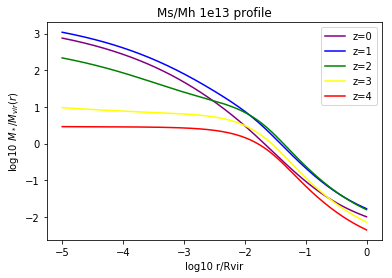

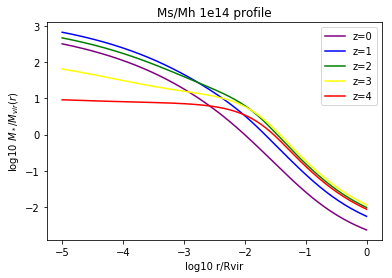

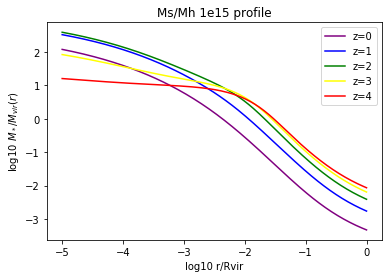

In [32]:
z = 0
z0 = 0
redshift = np.linspace(z0, 10, 100)
Mvir0 = [1e11,1e12,1e13,1e14,1e15,]
galaxy_mass_assembly(Mvir0, z0, z)

Msh1 = galaxy_mass_assembly(Mvir0[0], z0, 0.)
Msh2 = galaxy_mass_assembly(Mvir0[0], z0, 1.)
Msh3 = galaxy_mass_assembly(Mvir0[0], z0, 2.)
Msh4 = galaxy_mass_assembly(Mvir0[0], z0, 3.)
Msh5 = galaxy_mass_assembly(Mvir0[0], z0, 4.)

Mvh1 = halo_mass_assembly(Mvir0[0], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[0], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[0], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[0], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[0], z0, 4.)

Rvir1 = r_vir(Mvh1, Om_mat_cero, Om_lambda_cero, 0.)
Rvir2 = r_vir(Mvh2, Om_mat_cero, Om_lambda_cero, 1.)
Rvir3 = r_vir(Mvh3, Om_mat_cero, Om_lambda_cero, 2.)
Rvir4 = r_vir(Mvh4, Om_mat_cero, Om_lambda_cero, 3.)
Rvir5 = r_vir(Mvh5, Om_mat_cero, Om_lambda_cero, 4.)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio1.append(mass_profile(r1, Msh1, 0.)/M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(mass_profile(r2, Msh2, 1.)/M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(mass_profile(r3, Msh3, 2.)/M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(mass_profile(r4, Msh4, 3.)/M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(mass_profile(r5, Msh5, 4.)/M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Ms/Mh1e11 profile')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Rvir')
plt.ylabel('log10 $M_*/M_{vir} (r) $')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh1e11_profile.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

##############################################################
Msh1 = galaxy_mass_assembly(Mvir0[1], z0, 0.)
Msh2 = galaxy_mass_assembly(Mvir0[1], z0, 1.)
Msh3 = galaxy_mass_assembly(Mvir0[1], z0, 2.)
Msh4 = galaxy_mass_assembly(Mvir0[1], z0, 3.)
Msh5 = galaxy_mass_assembly(Mvir0[1], z0, 4.)

Mvh1 = halo_mass_assembly(Mvir0[1], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[1], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[1], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[1], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[1], z0, 4.)

Rvir1 = r_vir(Mvh1, Om_mat_cero, Om_lambda_cero, 0.)
Rvir2 = r_vir(Mvh2, Om_mat_cero, Om_lambda_cero, 1.)
Rvir3 = r_vir(Mvh3, Om_mat_cero, Om_lambda_cero, 2.)
Rvir4 = r_vir(Mvh4, Om_mat_cero, Om_lambda_cero, 3.)
Rvir5 = r_vir(Mvh5, Om_mat_cero, Om_lambda_cero, 4.)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio1.append(mass_profile(r1, Msh1, 0.)/M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(mass_profile(r2, Msh2, 1.)/M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(mass_profile(r3, Msh3, 2.)/M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(mass_profile(r4, Msh4, 3.)/M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(mass_profile(r5, Msh5, 4.)/M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Ms/Mh 1e12 profile')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Rvir')
plt.ylabel('log10 $M_*/M_{vir} (r) $')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh1e12_profile.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

##############################################################
Msh1 = galaxy_mass_assembly(Mvir0[2], z0, 0.)
Msh2 = galaxy_mass_assembly(Mvir0[2], z0, 1.)
Msh3 = galaxy_mass_assembly(Mvir0[2], z0, 2.)
Msh4 = galaxy_mass_assembly(Mvir0[2], z0, 3.)
Msh5 = galaxy_mass_assembly(Mvir0[2], z0, 4.)

Mvh1 = halo_mass_assembly(Mvir0[2], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[2], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[2], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[2], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[2], z0, 4.)

Rvir1 = r_vir(Mvh1, Om_mat_cero, Om_lambda_cero, 0.)
Rvir2 = r_vir(Mvh2, Om_mat_cero, Om_lambda_cero, 1.)
Rvir3 = r_vir(Mvh3, Om_mat_cero, Om_lambda_cero, 2.)
Rvir4 = r_vir(Mvh4, Om_mat_cero, Om_lambda_cero, 3.)
Rvir5 = r_vir(Mvh5, Om_mat_cero, Om_lambda_cero, 4.)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio1.append(mass_profile(r1, Msh1, 0.)/M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(mass_profile(r2, Msh2, 1.)/M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(mass_profile(r3, Msh3, 2.)/M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(mass_profile(r4, Msh4, 3.)/M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(mass_profile(r5, Msh5, 4.)/M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Ms/Mh 1e13 profile')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Rvir')
plt.ylabel('log10 $M_*/M_{vir} (r) $')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh1e13_profile.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

##############################################################
Msh1 = galaxy_mass_assembly(Mvir0[3], z0, 0.)
Msh2 = galaxy_mass_assembly(Mvir0[3], z0, 1.)
Msh3 = galaxy_mass_assembly(Mvir0[3], z0, 2.)
Msh4 = galaxy_mass_assembly(Mvir0[3], z0, 3.)
Msh5 = galaxy_mass_assembly(Mvir0[3], z0, 4.)

Mvh1 = halo_mass_assembly(Mvir0[3], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[3], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[3], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[3], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[3], z0, 4.)

Rvir1 = r_vir(Mvh1, Om_mat_cero, Om_lambda_cero, 0.)
Rvir2 = r_vir(Mvh2, Om_mat_cero, Om_lambda_cero, 1.)
Rvir3 = r_vir(Mvh3, Om_mat_cero, Om_lambda_cero, 2.)
Rvir4 = r_vir(Mvh4, Om_mat_cero, Om_lambda_cero, 3.)
Rvir5 = r_vir(Mvh5, Om_mat_cero, Om_lambda_cero, 4.)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio1.append(mass_profile(r1, Msh1, 0.)/M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(mass_profile(r2, Msh2, 1.)/M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(mass_profile(r3, Msh3, 2.)/M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(mass_profile(r4, Msh4, 3.)/M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(mass_profile(r5, Msh5, 4.)/M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Ms/Mh 1e14 profile')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Rvir')
plt.ylabel('log10 $M_*/M_{vir} (r) $')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh1e14_profile.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

##############################################################
Msh1 = galaxy_mass_assembly(Mvir0[4], z0, 0.)
Msh2 = galaxy_mass_assembly(Mvir0[4], z0, 1.)
Msh3 = galaxy_mass_assembly(Mvir0[4], z0, 2.)
Msh4 = galaxy_mass_assembly(Mvir0[4], z0, 3.)
Msh5 = galaxy_mass_assembly(Mvir0[4], z0, 4.)

Mvh1 = halo_mass_assembly(Mvir0[4], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[4], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[4], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[4], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[4], z0, 4.)

Rvir1 = r_vir(Mvh1, Om_mat_cero, Om_lambda_cero, 0.)
Rvir2 = r_vir(Mvh2, Om_mat_cero, Om_lambda_cero, 1.)
Rvir3 = r_vir(Mvh3, Om_mat_cero, Om_lambda_cero, 2.)
Rvir4 = r_vir(Mvh4, Om_mat_cero, Om_lambda_cero, 3.)
Rvir5 = r_vir(Mvh5, Om_mat_cero, Om_lambda_cero, 4.)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, 0, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Rvir1 * r
    r2 = Rvir2 * r
    r3 = Rvir3 * r
    r4 = Rvir4 * r
    r5 = Rvir5 * r
    ratio1.append(mass_profile(r1, Msh1, 0.)/M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(mass_profile(r2, Msh2, 1.)/M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(mass_profile(r3, Msh3, 2.)/M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(mass_profile(r4, Msh4, 3.)/M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(mass_profile(r5, Msh5, 4.)/M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Ms/Mh 1e15 profile')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Rvir')
plt.ylabel('log10 $M_*/M_{vir} (r) $')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh1e15_profile.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

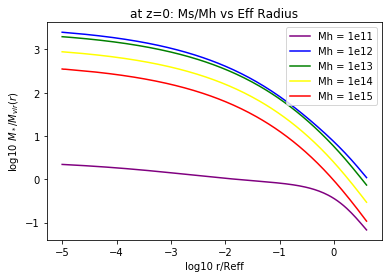

In [34]:
z= 0
z0= 0
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)


Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])

Reff1 = avg_rad_eff(Ms1, z)
Reff2 = avg_rad_eff(Ms2, z)
Reff3 = avg_rad_eff(Ms3, z)
Reff4 = avg_rad_eff(Ms4, z)
Reff5 = avg_rad_eff(Ms5, z)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, .6, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Reff1 * r
    r2 = Reff2 * r
    r3 = Reff3 * r
    r4 = Reff4 * r
    r5 = Reff5 * r
    ratio1.append(mass_profile(r1, Ms1, z0)/M_h_profile(Mvir[0], r1,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio2.append(mass_profile(r2, Ms2, z0)/M_h_profile(Mvir[1], r2,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio3.append(mass_profile(r3, Ms3, z0)/M_h_profile(Mvir[2], r3,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio4.append(mass_profile(r4, Ms4, z0)/M_h_profile(Mvir[3], r4,  Om_mat_cero, Om_lambda_cero, z0, h))
    ratio5.append(mass_profile(r5, Ms5, z0)/M_h_profile(Mvir[4], r5,  Om_mat_cero, Om_lambda_cero, z0, h))

plt.title('at z=0: Ms/Mh vs Eff Radius')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='Mh = 1e11')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='Mh = 1e12')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='Mh = 1e13')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='Mh = 1e14')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='Mh = 1e15')

plt.xlabel('log10 r/Reff')
plt.ylabel('log10 $M_*/M_{vir} (r)$')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh_vs_Reff_z0.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


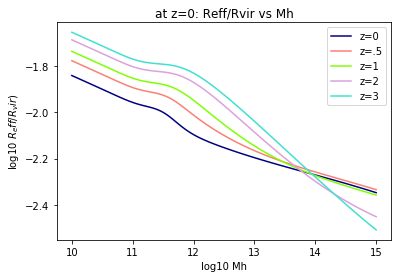

In [35]:
z1= 0.
z2= 0.5
z3= 1.
z4= 2.
z5= 3.

Mhalo = np.logspace(10, 15, 100)
Ms = SHMR(z,Mhalo)

Rvir1 = r_vir(Mhalo, Om_mat_cero, Om_lambda_cero, z1)
Rvir2 = r_vir(Mhalo, Om_mat_cero, Om_lambda_cero, z2)
Rvir3 = r_vir(Mhalo, Om_mat_cero, Om_lambda_cero, z3)
Rvir4 = r_vir(Mhalo, Om_mat_cero, Om_lambda_cero, z4)
Rvir5 = r_vir(Mhalo, Om_mat_cero, Om_lambda_cero, z5)


ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

for i in range(0, 100):
    m_s = Ms[i]
    ratio1.append(avg_rad_eff(m_s, z1) /Rvir1[i])
    ratio2.append(avg_rad_eff(m_s, z2) /Rvir2[i])
    ratio3.append(avg_rad_eff(m_s, z3) /Rvir3[i])
    ratio4.append(avg_rad_eff(m_s, z4) /Rvir4[i])
    ratio5.append(avg_rad_eff(m_s, z5) /Rvir5[i])
    
    
plt.title('at z=0: Reff/Rvir vs Mh')
plt.plot(np.log10(Mhalo), np.log10(ratio1), '-k', color='navy', label='z=0')
plt.plot(np.log10(Mhalo), np.log10(ratio2), '-k', color='salmon', label='z=.5')
plt.plot(np.log10(Mhalo), np.log10(ratio3), '-k', color='chartreuse', label='z=1')
plt.plot(np.log10(Mhalo), np.log10(ratio4), '-k', color='plum', label='z=2')
plt.plot(np.log10(Mhalo), np.log10(ratio5), '-k', color='turquoise', label='z=3')

plt.xlabel('log10 Mh')
plt.ylabel('log10 $R_eff/R_vir)$')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/ReffRvir_vs_Mh_z0.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


#Ms = np.logspace(9, 12, 30)
#reff_all = []
#for i in range(0, 30):
    #m_s = Ms[i]
    #reff_all.append(avg_rad_eff(m_s, z))


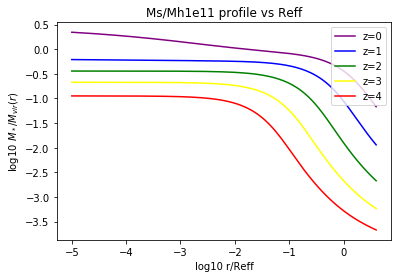

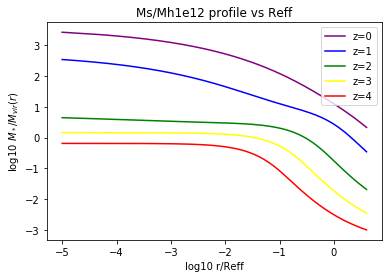

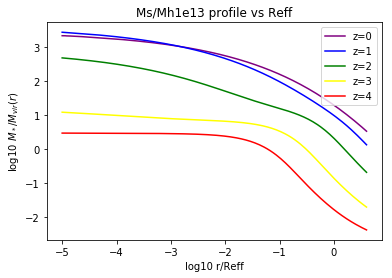

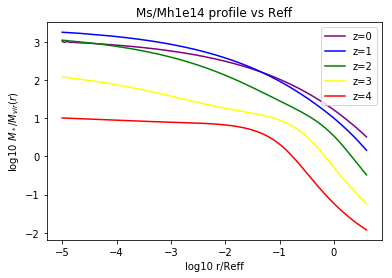

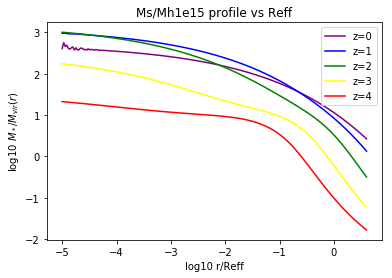

In [36]:
z = 0
z0 = 0
redshift = np.linspace(z0, 10, 100)
Mvir0 = [1e11,1e12,1e13,1e14,1e15,]
galaxy_mass_assembly(Mvir0, z0, z)

Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])

Msh1 = galaxy_mass_assembly(Mvir0[0], z0, 0.)
Msh2 = galaxy_mass_assembly(Mvir0[0], z0, 1.)
Msh3 = galaxy_mass_assembly(Mvir0[0], z0, 2.)
Msh4 = galaxy_mass_assembly(Mvir0[0], z0, 3.)
Msh5 = galaxy_mass_assembly(Mvir0[0], z0, 4.)

Mvh1 = halo_mass_assembly(Mvir0[0], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[0], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[0], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[0], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[0], z0, 4.)

Reff1 = avg_rad_eff(Ms1, z)
Reff2 = avg_rad_eff(Ms2, z)
Reff3 = avg_rad_eff(Ms3, z)
Reff4 = avg_rad_eff(Ms4, z)
Reff5 = avg_rad_eff(Ms5, z)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, .6, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Reff1 * r
    r2 = Reff2 * r
    r3 = Reff3 * r
    r4 = Reff4 * r
    r5 = Reff5 * r
    ratio1.append(mass_profile(r1, Msh1, 0.)/M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(mass_profile(r2, Msh2, 1.)/M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(mass_profile(r3, Msh3, 2.)/M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(mass_profile(r4, Msh4, 3.)/M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(mass_profile(r5, Msh5, 4.)/M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Ms/Mh1e11 profile vs Reff')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Reff')
plt.ylabel('log10 $M_*/M_{vir} (r) $')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh1e11_profileReff.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()
##############################################################

Msh1 = galaxy_mass_assembly(Mvir0[1], z0, 0.)
Msh2 = galaxy_mass_assembly(Mvir0[1], z0, 1.)
Msh3 = galaxy_mass_assembly(Mvir0[1], z0, 2.)
Msh4 = galaxy_mass_assembly(Mvir0[1], z0, 3.)
Msh5 = galaxy_mass_assembly(Mvir0[1], z0, 4.)

Mvh1 = halo_mass_assembly(Mvir0[1], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[1], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[1], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[1], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[1], z0, 4.)

Reff1 = avg_rad_eff(Ms1, z)
Reff2 = avg_rad_eff(Ms2, z)
Reff3 = avg_rad_eff(Ms3, z)
Reff4 = avg_rad_eff(Ms4, z)
Reff5 = avg_rad_eff(Ms5, z)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, .6, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Reff1 * r
    r2 = Reff2 * r
    r3 = Reff3 * r
    r4 = Reff4 * r
    r5 = Reff5 * r
    ratio1.append(mass_profile(r1, Msh1, 0.)/M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(mass_profile(r2, Msh2, 1.)/M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(mass_profile(r3, Msh3, 2.)/M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(mass_profile(r4, Msh4, 3.)/M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(mass_profile(r5, Msh5, 4.)/M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Ms/Mh1e12 profile vs Reff')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Reff')
plt.ylabel('log10 $M_*/M_{vir} (r) $')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh1e12_profileReff.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()
##############################################################

Msh1 = galaxy_mass_assembly(Mvir0[2], z0, 0.)
Msh2 = galaxy_mass_assembly(Mvir0[2], z0, 1.)
Msh3 = galaxy_mass_assembly(Mvir0[2], z0, 2.)
Msh4 = galaxy_mass_assembly(Mvir0[2], z0, 3.)
Msh5 = galaxy_mass_assembly(Mvir0[2], z0, 4.)

Mvh1 = halo_mass_assembly(Mvir0[2], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[2], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[2], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[2], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[2], z0, 4.)

Reff1 = avg_rad_eff(Ms1, z)
Reff2 = avg_rad_eff(Ms2, z)
Reff3 = avg_rad_eff(Ms3, z)
Reff4 = avg_rad_eff(Ms4, z)
Reff5 = avg_rad_eff(Ms5, z)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, .6, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Reff1 * r
    r2 = Reff2 * r
    r3 = Reff3 * r
    r4 = Reff4 * r
    r5 = Reff5 * r
    ratio1.append(mass_profile(r1, Msh1, 0.)/M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(mass_profile(r2, Msh2, 1.)/M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(mass_profile(r3, Msh3, 2.)/M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(mass_profile(r4, Msh4, 3.)/M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(mass_profile(r5, Msh5, 4.)/M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Ms/Mh1e13 profile vs Reff')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Reff')
plt.ylabel('log10 $M_*/M_{vir} (r) $')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh1e13_profileReff.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

##############################################################

Msh1 = galaxy_mass_assembly(Mvir0[3], z0, 0.)
Msh2 = galaxy_mass_assembly(Mvir0[3], z0, 1.)
Msh3 = galaxy_mass_assembly(Mvir0[3], z0, 2.)
Msh4 = galaxy_mass_assembly(Mvir0[3], z0, 3.)
Msh5 = galaxy_mass_assembly(Mvir0[3], z0, 4.)

Mvh1 = halo_mass_assembly(Mvir0[3], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[3], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[3], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[3], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[3], z0, 4.)

Reff1 = avg_rad_eff(Ms1, z)
Reff2 = avg_rad_eff(Ms2, z)
Reff3 = avg_rad_eff(Ms3, z)
Reff4 = avg_rad_eff(Ms4, z)
Reff5 = avg_rad_eff(Ms5, z)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, .6, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Reff1 * r
    r2 = Reff2 * r
    r3 = Reff3 * r
    r4 = Reff4 * r
    r5 = Reff5 * r
    ratio1.append(mass_profile(r1, Msh1, 0.)/M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(mass_profile(r2, Msh2, 1.)/M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(mass_profile(r3, Msh3, 2.)/M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(mass_profile(r4, Msh4, 3.)/M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(mass_profile(r5, Msh5, 4.)/M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Ms/Mh1e14 profile vs Reff')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Reff')
plt.ylabel('log10 $M_*/M_{vir} (r) $')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh1e14_profileReff.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

##############################################################

Msh1 = galaxy_mass_assembly(Mvir0[4], z0, 0.)
Msh2 = galaxy_mass_assembly(Mvir0[4], z0, 1.)
Msh3 = galaxy_mass_assembly(Mvir0[4], z0, 2.)
Msh4 = galaxy_mass_assembly(Mvir0[4], z0, 3.)
Msh5 = galaxy_mass_assembly(Mvir0[4], z0, 4.)

Mvh1 = halo_mass_assembly(Mvir0[4], z0, 0.)
Mvh2 = halo_mass_assembly(Mvir0[4], z0, 1.)
Mvh3 = halo_mass_assembly(Mvir0[4], z0, 2.)
Mvh4 = halo_mass_assembly(Mvir0[4], z0, 3.)
Mvh5 = halo_mass_assembly(Mvir0[4], z0, 4.)

Reff1 = avg_rad_eff(Ms1, z)
Reff2 = avg_rad_eff(Ms2, z)
Reff3 = avg_rad_eff(Ms3, z)
Reff4 = avg_rad_eff(Ms4, z)
Reff5 = avg_rad_eff(Ms5, z)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

radius = np.linspace(-5, .6, 200)
for i in range(0, 200):
    r = 10**radius[i]
    r1 = Reff1 * r
    r2 = Reff2 * r
    r3 = Reff3 * r
    r4 = Reff4 * r
    r5 = Reff5 * r
    ratio1.append(mass_profile(r1, Msh1, 0.)/M_h_profile(Mvh1, r1,  Om_mat_cero, Om_lambda_cero, 0., h))
    ratio2.append(mass_profile(r2, Msh2, 1.)/M_h_profile(Mvh2, r2,  Om_mat_cero, Om_lambda_cero, 1., h))
    ratio3.append(mass_profile(r3, Msh3, 2.)/M_h_profile(Mvh3, r3,  Om_mat_cero, Om_lambda_cero, 2., h))
    ratio4.append(mass_profile(r4, Msh4, 3.)/M_h_profile(Mvh4, r4,  Om_mat_cero, Om_lambda_cero, 3., h))
    ratio5.append(mass_profile(r5, Msh5, 4.)/M_h_profile(Mvh5, r5,  Om_mat_cero, Om_lambda_cero, 4., h))

plt.title('Ms/Mh1e15 profile vs Reff')
plt.plot(radius, np.log10(ratio1), '-k', color='purple', label='z=0')
plt.plot(radius, np.log10(ratio2), '-k', color='blue', label='z=1')
plt.plot(radius, np.log10(ratio3), '-k', color='green', label='z=2')
plt.plot(radius, np.log10(ratio4), '-k', color='yellow', label='z=3')
plt.plot(radius, np.log10(ratio5), '-k', color='red', label='z=4')

plt.xlabel('log10 r/Reff')
plt.ylabel('log10 $M_*/M_{vir} (r) $')
plt.legend(loc='upper right')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/MsMh1e15_profileReff.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

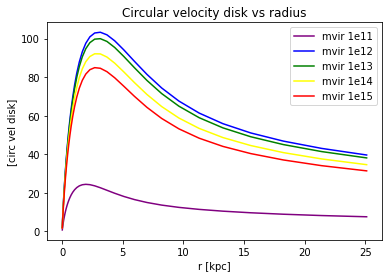

In [37]:
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)
z= 0.

Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])

Md1 = fSF(Ms1,z) * Ms1
Md2 = fSF(Ms2,z) * Ms2
Md3 = fSF(Ms3,z) * Ms3
Md4 = fSF(Ms4,z) * Ms4
Md5 = fSF(Ms5,z) * Ms5

circ_vel1 = []
circ_vel2 = []
circ_vel3 = []
circ_vel4 = []
circ_vel5 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    circ_vel1.append(circ_vel_disk(Md1, r, z))
    circ_vel2.append(circ_vel_disk(Md2, r, z))
    circ_vel3.append(circ_vel_disk(Md3, r, z))
    circ_vel4.append(circ_vel_disk(Md4, r, z))
    circ_vel5.append(circ_vel_disk(Md5, r, z))

plt.title('Circular velocity disk vs radius')
plt.plot(radius, circ_vel1, color='purple', label='mvir 1e11')
plt.plot(radius, circ_vel2, color='blue', label='mvir 1e12')
plt.plot(radius, circ_vel3, color='green', label='mvir 1e13')
plt.plot(radius, circ_vel4, color='yellow', label='mvir 1e14')
plt.plot(radius, circ_vel5, color='red', label='mvir 1e15')

plt.xlabel('r [kpc]')
plt.ylabel('[circ vel disk]')
plt.legend(loc='upper right')
plt.savefig('circ_vel_disk_vs_rad.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

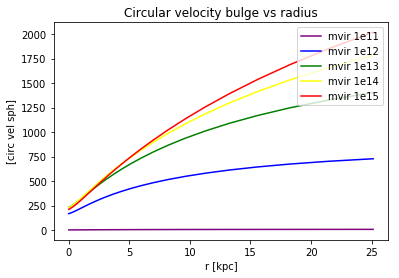

In [38]:
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)
z= 0.1

Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])

circ_vel_sph1 = []
circ_vel_sph2 = []
circ_vel_sph3 = []
circ_vel_sph4 = []
circ_vel_sph5 = []

Msph1 = (1. - fSF(Ms1,z)) * Ms1
Msph2 = (1. - fSF(Ms2,z)) * Ms2
Msph3 = (1. - fSF(Ms3,z)) * Ms3
Msph4 = (1. - fSF(Ms4,z)) * Ms4
Msph5 = (1. - fSF(Ms5,z)) * Ms5

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    circ_vel_sph1.append(circ_vel_bulge(Msph1, r, z))
    circ_vel_sph2.append(circ_vel_bulge(Msph2, r, z))
    circ_vel_sph3.append(circ_vel_bulge(Msph3, r, z))
    circ_vel_sph4.append(circ_vel_bulge(Msph4, r, z))
    circ_vel_sph5.append(circ_vel_bulge(Msph5, r, z))

plt.title('Circular velocity bulge vs radius')
plt.plot(radius, circ_vel_sph1, color='purple', label='mvir 1e11')
plt.plot(radius, circ_vel_sph2, color='blue', label='mvir 1e12')
plt.plot(radius, circ_vel_sph3, color='green', label='mvir 1e13')
plt.plot(radius, circ_vel_sph4, color='yellow', label='mvir 1e14')
plt.plot(radius, circ_vel_sph5, color='red', label='mvir 1e15')

plt.xlabel('r [kpc]')
plt.ylabel('[circ vel sph]')
plt.legend(loc='upper right')
plt.savefig('circ_vel_bulge_vs_rad.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

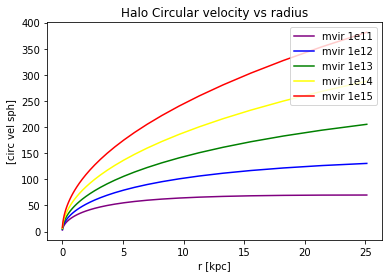

In [39]:
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)
z= 0.
circ_vel_halo1 = []
circ_vel_halo2 = []
circ_vel_halo3 = []
circ_vel_halo4 = []
circ_vel_halo5 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    circ_vel_halo1.append(circ_vel_halo(Mvir[0], r,  Om_mat_cero, Om_lambda_cero, z, h))
    circ_vel_halo2.append(circ_vel_halo(Mvir[1], r,  Om_mat_cero, Om_lambda_cero, z, h))
    circ_vel_halo3.append(circ_vel_halo(Mvir[2], r,  Om_mat_cero, Om_lambda_cero, z, h))
    circ_vel_halo4.append(circ_vel_halo(Mvir[3], r,  Om_mat_cero, Om_lambda_cero, z, h))
    circ_vel_halo5.append(circ_vel_halo(Mvir[4], r,  Om_mat_cero, Om_lambda_cero, z, h))

plt.title('Halo Circular velocity vs radius')
plt.plot(radius, circ_vel_halo1, color='purple', label='mvir 1e11')
plt.plot(radius, circ_vel_halo2, color='blue', label='mvir 1e12')
plt.plot(radius, circ_vel_halo3, color='green', label='mvir 1e13')
plt.plot(radius, circ_vel_halo4, color='yellow', label='mvir 1e14')
plt.plot(radius, circ_vel_halo5, color='red', label='mvir 1e15')

plt.xlabel('r [kpc]')
plt.ylabel('[circ vel sph]')
plt.legend(loc='upper right')
plt.savefig('circ_vel_halo_vs_rad.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

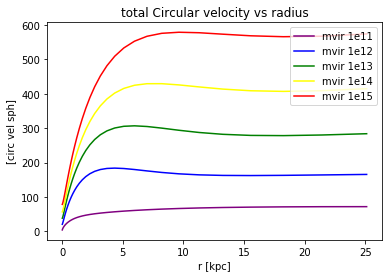

In [40]:
Mvir = (1e11, 1e12, 1e13, 1e14, 1e15)

Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])

z= 0.1

circ_vel_tot1 = []
circ_vel_tot2 = []
circ_vel_tot3 = []
circ_vel_tot4 = []
circ_vel_tot5 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    circ_vel_tot1.append(circ_vel_total(Mvir[0], Ms1, r,  Om_mat_cero, Om_lambda_cero, z, h))
    circ_vel_tot2.append(circ_vel_total(Mvir[1], Ms2, r,  Om_mat_cero, Om_lambda_cero, z, h))
    circ_vel_tot3.append(circ_vel_total(Mvir[2], Ms3, r,  Om_mat_cero, Om_lambda_cero, z, h))
    circ_vel_tot4.append(circ_vel_total(Mvir[3], Ms4, r,  Om_mat_cero, Om_lambda_cero, z, h))
    circ_vel_tot5.append(circ_vel_total(Mvir[4], Ms5, r,  Om_mat_cero, Om_lambda_cero, z, h))

plt.title('total Circular velocity vs radius')
plt.plot(radius, circ_vel_tot1, color='purple', label='mvir 1e11')
plt.plot(radius, circ_vel_tot2, color='blue', label='mvir 1e12')
plt.plot(radius, circ_vel_tot3, color='green', label='mvir 1e13')
plt.plot(radius, circ_vel_tot4, color='yellow', label='mvir 1e14')
plt.plot(radius, circ_vel_tot5, color='red', label='mvir 1e15')

plt.xlabel('r [kpc]')
plt.ylabel('[circ vel sph]')
plt.legend(loc='upper right')
plt.savefig('circ_vel_total_vs_rad.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

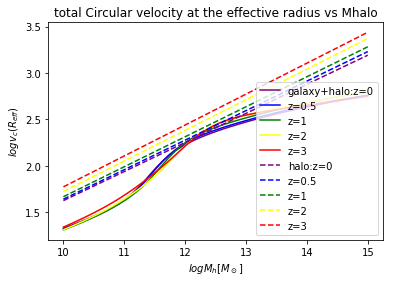

In [41]:
z1= 0.1
z2= 0.5
z3= 1.
z4= 2.
z5= 3.

Mhalo = np.logspace(10, 15, 50)
vmax_h1 = Vmax(Mhalo,z1)
vmax_h2 = Vmax(Mhalo,z2)
vmax_h3 = Vmax(Mhalo,z3)
vmax_h4 = Vmax(Mhalo,z4)
vmax_h5 = Vmax(Mhalo,z5)
circ_vel_tot1 = []
circ_vel_tot2 = []
circ_vel_tot3 = []
circ_vel_tot4 = []
circ_vel_tot5 = []

for i in range(0, 50):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = avg_rad_eff(m_s1, z1)
    reff_all2 = avg_rad_eff(m_s2, z2)
    reff_all3 = avg_rad_eff(m_s3, z3)
    reff_all4 = avg_rad_eff(m_s4, z4)
    reff_all5 = avg_rad_eff(m_s5, z5)
    circ_vel_tot1.append(circ_vel_total(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, h))
    circ_vel_tot2.append(circ_vel_total(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, h))
    circ_vel_tot3.append(circ_vel_total(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, h))
    circ_vel_tot4.append(circ_vel_total(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, h))
    circ_vel_tot5.append(circ_vel_total(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, h))

plt.title('total Circular velocity at the effective radius vs Mhalo')
plt.plot(np.log10(Mhalo), np.log10(circ_vel_tot1), color='purple', label='galaxy+halo:z=0')
plt.plot(np.log10(Mhalo), np.log10(circ_vel_tot2), color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(circ_vel_tot3), color='green', label='z=1')
plt.plot(np.log10(Mhalo), np.log10(circ_vel_tot4), color='yellow', label='z=2')
plt.plot(np.log10(Mhalo), np.log10(circ_vel_tot5), color='red', label='z=3')
plt.plot(np.log10(Mhalo), np.log10(vmax_h1), '--k', color='purple', label='halo:z=0')
plt.plot(np.log10(Mhalo), np.log10(vmax_h2), '--k', color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(vmax_h3), '--k', color='green', label='z=1')
plt.plot(np.log10(Mhalo), np.log10(vmax_h4), '--k', color='yellow', label='z=2')
plt.plot(np.log10(Mhalo), np.log10(vmax_h5), '--k', color='red', label='z=3')


plt.xlabel('$log M_{h}[M_\odot]$')
plt.ylabel('$log v_c(R_{eff})$')
plt.legend(loc='lower right')
plt.savefig('circ_vel_total_vs_rad.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

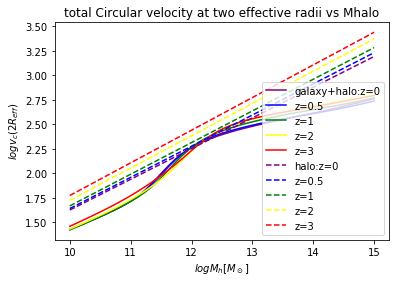

In [42]:
z1= 0.1
z2= 0.5
z3= 1.
z4= 2.
z5= 3.

Mhalo = np.logspace(10, 15, 50)
vmax_h1 = Vmax(Mhalo,z1)
vmax_h2 = Vmax(Mhalo,z2)
vmax_h3 = Vmax(Mhalo,z3)
vmax_h4 = Vmax(Mhalo,z4)
vmax_h5 = Vmax(Mhalo,z5)
circ_vel_tot1 = []
circ_vel_tot2 = []
circ_vel_tot3 = []
circ_vel_tot4 = []
circ_vel_tot5 = []

for i in range(0, 50):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = 2 * avg_rad_eff(m_s1, z1)
    reff_all2 = 2 * avg_rad_eff(m_s2, z2)
    reff_all3 = 2 * avg_rad_eff(m_s3, z3)
    reff_all4 = 2 * avg_rad_eff(m_s4, z4)
    reff_all5 = 2 * avg_rad_eff(m_s5, z5)
    circ_vel_tot1.append(circ_vel_total(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, h))
    circ_vel_tot2.append(circ_vel_total(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, h))
    circ_vel_tot3.append(circ_vel_total(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, h))
    circ_vel_tot4.append(circ_vel_total(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, h))
    circ_vel_tot5.append(circ_vel_total(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, h))

plt.title('total Circular velocity at two effective radii vs Mhalo')
plt.plot(np.log10(Mhalo), np.log10(circ_vel_tot1), color='purple', label='galaxy+halo:z=0')
plt.plot(np.log10(Mhalo), np.log10(circ_vel_tot2), color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(circ_vel_tot3), color='green', label='z=1')
plt.plot(np.log10(Mhalo), np.log10(circ_vel_tot4), color='yellow', label='z=2')
plt.plot(np.log10(Mhalo), np.log10(circ_vel_tot5), color='red', label='z=3')
plt.plot(np.log10(Mhalo), np.log10(vmax_h1), '--k', color='purple', label='halo:z=0')
plt.plot(np.log10(Mhalo), np.log10(vmax_h2), '--k', color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(vmax_h3), '--k', color='green', label='z=1')
plt.plot(np.log10(Mhalo), np.log10(vmax_h4), '--k', color='yellow', label='z=2')
plt.plot(np.log10(Mhalo), np.log10(vmax_h5), '--k', color='red', label='z=3')

plt.xlabel('$log M_{h}[M_\odot]$')
plt.ylabel('$log v_c(2R_{eff})$')
plt.legend(loc='lower right')
plt.savefig('circ_vel_total_vs_rad.pdf',format='pdf',dpi=200, bbox_inches= 'tight')
plt.show()

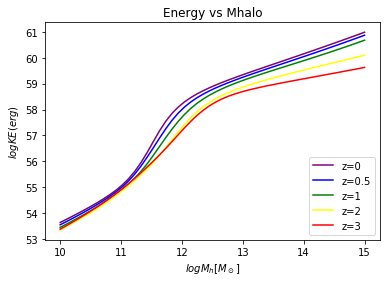

In [17]:
z1= 0.1
z2= 0.5
z3= 1.
z4= 2.
z5= 3.

Mhalo = np.logspace(10, 15, 50)

KE1 = []
KE2 = []
KE3 = []
KE4 = []
KE5 = []


for i in range(0, 50):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = avg_rad_eff(m_s1, z1)
    reff_all2 = avg_rad_eff(m_s2, z2)
    reff_all3 = avg_rad_eff(m_s3, z3)
    reff_all4 = avg_rad_eff(m_s4, z4)
    reff_all5 = avg_rad_eff(m_s5, z5)
    KE1.append(KE(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, h))
    KE2.append(KE(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, h))
    KE3.append(KE(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, h))
    KE4.append(KE(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, h))
    KE5.append(KE(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, h))

    
plt.title('Energy vs Mhalo')
plt.plot(np.log10(Mhalo), np.log10(KE1), color='purple', label='z=0')
plt.plot(np.log10(Mhalo), np.log10(KE2), color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(KE3), color='green', label='z=1')
plt.plot(np.log10(Mhalo), np.log10(KE4), color='yellow', label='z=2')
plt.plot(np.log10(Mhalo), np.log10(KE5), color='red', label='z=3')

plt.xlabel('$log M_{h}[M_\odot]$')
plt.ylabel('$log KE({erg})$')
plt.legend(loc='lower right')
plt.savefig('ke.pdf',format='pdf',dpi=200, bbox_inches= 'tight')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/KE_VS_MH.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

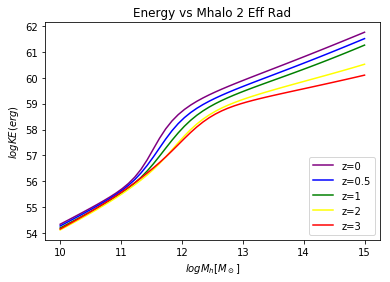

In [16]:
z1= 0.1
z2= 0.5
z3= 1.
z4= 2.
z5= 3.

Mhalo = np.logspace(10, 15, 50)

KE1 = []
KE2 = []
KE3 = []
KE4 = []
KE5 = []


for i in range(0, 50):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = 2*avg_rad_eff(m_s1, z1)
    reff_all2 = 2*avg_rad_eff(m_s2, z2)
    reff_all3 = 2*avg_rad_eff(m_s3, z3)
    reff_all4 = 2*avg_rad_eff(m_s4, z4)
    reff_all5 = 2*avg_rad_eff(m_s5, z5)
    KE1.append(KE(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, h))
    KE2.append(KE(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, h))
    KE3.append(KE(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, h))
    KE4.append(KE(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, h))
    KE5.append(KE(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, h))

    
plt.title('Energy vs Mhalo 2 Eff Rad')
plt.plot(np.log10(Mhalo), np.log10(KE1), color='purple', label='z=0')
plt.plot(np.log10(Mhalo), np.log10(KE2), color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(KE3), color='green', label='z=1')
plt.plot(np.log10(Mhalo), np.log10(KE4), color='yellow', label='z=2')
plt.plot(np.log10(Mhalo), np.log10(KE5), color='red', label='z=3')

plt.xlabel('$log M_{h}[M_\odot]$')
plt.ylabel('$log KE({erg})$')
plt.legend(loc='lower right')
plt.savefig('ke.pdf',format='pdf',dpi=200, bbox_inches= 'tight')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/KE_VS_MH_2Reff.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

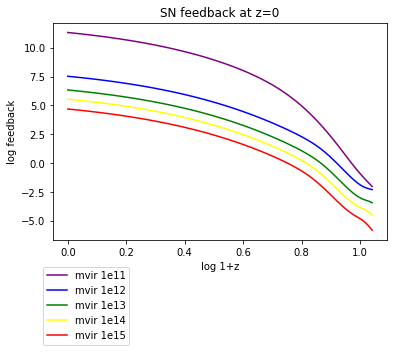

In [45]:
##### z=0 ######


redshift = np.linspace(z0, 10, 100)
Mvir = [1e11,1e12,1e13,1e14,1e15,]
z0 = 0
z= 0.1

Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])

Reff1 = avg_rad_eff(Ms1, z)
Reff2 = avg_rad_eff(Ms2, z)
Reff3 = avg_rad_eff(Ms3, z)
Reff4 = avg_rad_eff(Ms4, z)
Reff5 = avg_rad_eff(Ms5, z)


SNE_f1=[]
SNE_f2=[]
SNE_f3=[]
SNE_f4=[]
SNE_f5=[]

radius = np.linspace(-5, .6, 100)
for i in range(0, 100):
    r = 10**radius[i]
    r1 = Reff1 * r
    r2 = Reff2 * r
    r3 = Reff3 * r
    r4 = Reff4 * r
    r5 = Reff5 * r
    SNE_f1.append(SNE_feedback(Mvir[0], Ms1, r1,  Om_mat_cero, Om_lambda_cero, z, z0, h))
    SNE_f2.append(SNE_feedback(Mvir[1], Ms2, r2,  Om_mat_cero, Om_lambda_cero, z, z0, h))
    SNE_f3.append(SNE_feedback(Mvir[2], Ms3, r3,  Om_mat_cero, Om_lambda_cero, z, z0, h))
    SNE_f4.append(SNE_feedback(Mvir[3], Ms4, r4,  Om_mat_cero, Om_lambda_cero, z, z0, h))
    SNE_f5.append(SNE_feedback(Mvir[4], Ms5, r5,  Om_mat_cero, Om_lambda_cero, z, z0, h))
    

plt.title('SN feedback at z=0')
plt.plot(np.log10(1+redshift), np.log10(SNE_f1), '-k', color='purple', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(SNE_f2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(SNE_f3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(SNE_f4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(SNE_f5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log feedback')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/SN_feedback.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

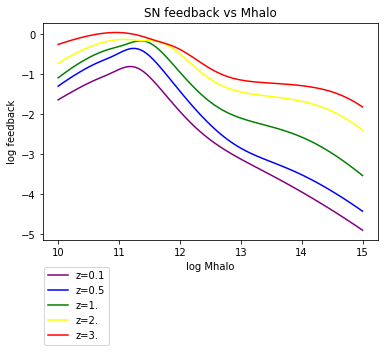

In [46]:
####### 1 effective radius #######

z1= 0.1
z2= 0.5
z3= 1.
z4= 2.
z5= 3.


Mhalo = np.logspace(10, 15, 100)

SNE_f1=[]
SNE_f2=[]
SNE_f3=[]
SNE_f4=[]
SNE_f5=[]


for i in range(0, 100):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = avg_rad_eff(m_s1, z1)
    reff_all2 = avg_rad_eff(m_s2, z2)
    reff_all3 = avg_rad_eff(m_s3, z3)
    reff_all4 = avg_rad_eff(m_s4, z4)
    reff_all5 = avg_rad_eff(m_s5, z5)
    SNE_f1.append(SNE_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    SNE_f2.append(SNE_feedback(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, z2, h))
    SNE_f3.append(SNE_feedback(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, z3, h))
    SNE_f4.append(SNE_feedback(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, z4, h))
    SNE_f5.append(SNE_feedback(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, z5, h))
    

    

plt.title('SN feedback vs Mhalo')
plt.plot(np.log10(Mhalo), np.log10(SNE_f1), '-k', color='purple', label='z=0.1')
plt.plot(np.log10(Mhalo), np.log10(SNE_f2), '-k', color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(SNE_f3), '-k', color='green', label='z=1.')
plt.plot(np.log10(Mhalo), np.log10(SNE_f4), '-k', color='yellow', label='z=2.')
plt.plot(np.log10(Mhalo), np.log10(SNE_f5), '-k', color='red', label='z=3.')
plt.xlabel('log Mhalo')
plt.ylabel('log feedback')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/SN_feedback_mh.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

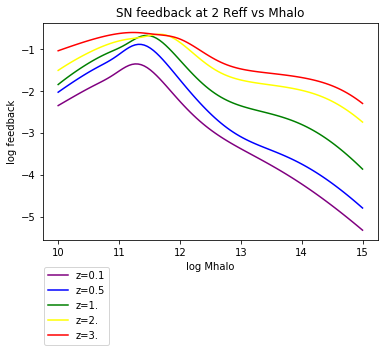

In [47]:
####### 2 effective radius #######
z0 = 0
z1= 0.1
z2= 0.5
z3= 1.
z4= 2.
z5= 3.


Mhalo = np.logspace(10, 15, 100)

SNE_f1=[]
SNE_f2=[]
SNE_f3=[]
SNE_f4=[]
SNE_f5=[]


for i in range(0, 100):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = 2 * avg_rad_eff(m_s1, z1)
    reff_all2 = 2 * avg_rad_eff(m_s2, z2)
    reff_all3 = 2 * avg_rad_eff(m_s3, z3)
    reff_all4 = 2 * avg_rad_eff(m_s4, z4)
    reff_all5 = 2 * avg_rad_eff(m_s5, z5)
    SNE_f1.append(SNE_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    SNE_f2.append(SNE_feedback(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, z2, h))
    SNE_f3.append(SNE_feedback(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, z3, h))
    SNE_f4.append(SNE_feedback(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, z4, h))
    SNE_f5.append(SNE_feedback(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, z5, h))
    

    

plt.title('SN feedback at 2 Reff vs Mhalo')
plt.plot(np.log10(Mhalo), np.log10(SNE_f1), '-k', color='purple', label='z=0.1')
plt.plot(np.log10(Mhalo), np.log10(SNE_f2), '-k', color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(SNE_f3), '-k', color='green', label='z=1.')
plt.plot(np.log10(Mhalo), np.log10(SNE_f4), '-k', color='yellow', label='z=2.')
plt.plot(np.log10(Mhalo), np.log10(SNE_f5), '-k', color='red', label='z=3.')
plt.xlabel('log Mhalo')
plt.ylabel('log feedback')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/SN_feedback_mh_2re.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

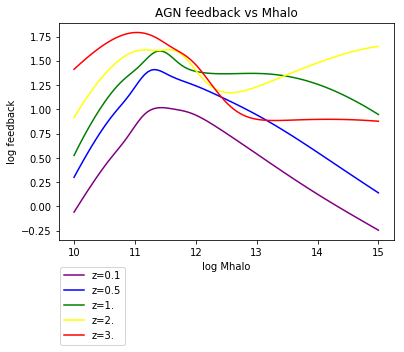

In [18]:


####### effective radius #######
z0 = 0
z1= 0.1
z2= 0.5
z3= 1.
z4= 2.
z5= 3.


Mhalo = np.logspace(10, 15, 100)

AGN_f1=[]
AGN_f2=[]
AGN_f3=[]
AGN_f4=[]
AGN_f5=[]


for i in range(0, 100):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = avg_rad_eff(m_s1, z1)
    reff_all2 = avg_rad_eff(m_s2, z2)
    reff_all3 = avg_rad_eff(m_s3, z3)
    reff_all4 = avg_rad_eff(m_s4, z4)
    reff_all5 = avg_rad_eff(m_s5, z5)
    AGN_f1.append(AGN_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    AGN_f2.append(AGN_feedback(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, z2, h))
    AGN_f3.append(AGN_feedback(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, z3, h))
    AGN_f4.append(AGN_feedback(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, z4, h))
    AGN_f5.append(AGN_feedback(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, z5, h))
    


    

plt.title('AGN feedback vs Mhalo')
plt.plot(np.log10(Mhalo), np.log10(AGN_f1), '-k', color='purple', label='z=0.1')
plt.plot(np.log10(Mhalo), np.log10(AGN_f2), '-k', color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(AGN_f3), '-k', color='green', label='z=1.')
plt.plot(np.log10(Mhalo), np.log10(AGN_f4), '-k', color='yellow', label='z=2.')
plt.plot(np.log10(Mhalo), np.log10(AGN_f5), '-k', color='red', label='z=3.')
plt.xlabel('log Mhalo')
plt.ylabel('log feedback')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/AGN_feedback_mh.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

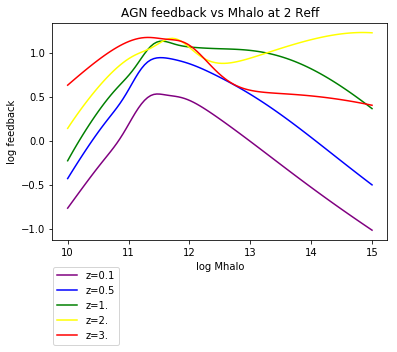

In [19]:


####### effective radius #######
z0 = 0
z1= 0.1
z2= 0.5
z3= 1.
z4= 2.
z5= 3.


Mhalo = np.logspace(10, 15, 100)

AGN_f1=[]
AGN_f2=[]
AGN_f3=[]
AGN_f4=[]
AGN_f5=[]


for i in range(0, 100):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = 2 * avg_rad_eff(m_s1, z1)
    reff_all2 = 2 * avg_rad_eff(m_s2, z2)
    reff_all3 = 2 * avg_rad_eff(m_s3, z3)
    reff_all4 = 2 * avg_rad_eff(m_s4, z4)
    reff_all5 = 2 * avg_rad_eff(m_s5, z5)
    AGN_f1.append(AGN_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    AGN_f2.append(AGN_feedback(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, z2, h))
    AGN_f3.append(AGN_feedback(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, z3, h))
    AGN_f4.append(AGN_feedback(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, z4, h))
    AGN_f5.append(AGN_feedback(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, z5, h))
    


    

plt.title('AGN feedback vs Mhalo at 2 Reff')
plt.plot(np.log10(Mhalo), np.log10(AGN_f1), '-k', color='purple', label='z=0.1')
plt.plot(np.log10(Mhalo), np.log10(AGN_f2), '-k', color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(AGN_f3), '-k', color='green', label='z=1.')
plt.plot(np.log10(Mhalo), np.log10(AGN_f4), '-k', color='yellow', label='z=2.')
plt.plot(np.log10(Mhalo), np.log10(AGN_f5), '-k', color='red', label='z=3.')
plt.xlabel('log Mhalo')
plt.ylabel('log feedback')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/AGN_feedback_mh_2Re.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

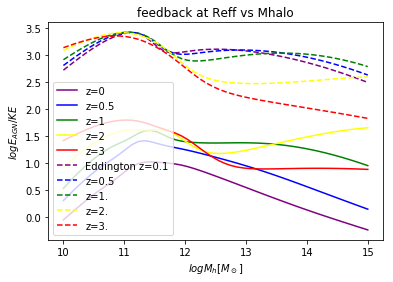

In [22]:
z1= 0.1
z2= 0.5
z3= 1.
z4= 2.
z5= 3.

Mhalo = np.logspace(10, 15, 50)

AGN_f1 = []
AGN_f2 = []
AGN_f3 = []
AGN_f4 = []
AGN_f5 = []

AGN_E_f1=[]
AGN_E_f2=[]
AGN_E_f3=[]
AGN_E_f4=[]
AGN_E_f5=[]

for i in range(0, 50):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = avg_rad_eff(m_s1, z1)
    reff_all2 = avg_rad_eff(m_s2, z2)
    reff_all3 = avg_rad_eff(m_s3, z3)
    reff_all4 = avg_rad_eff(m_s4, z4)
    reff_all5 = avg_rad_eff(m_s5, z5)
    AGN_f1.append(AGN_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    AGN_f2.append(AGN_feedback(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, z2, h))
    AGN_f3.append(AGN_feedback(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, z3, h))
    AGN_f4.append(AGN_feedback(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, z4, h))
    AGN_f5.append(AGN_feedback(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, z5, h))
    AGN_E_f1.append(AGN_feedback_eddigton(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    AGN_E_f2.append(AGN_feedback_eddigton(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, z2, h))
    AGN_E_f3.append(AGN_feedback_eddigton(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, z3, h))
    AGN_E_f4.append(AGN_feedback_eddigton(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, z4, h))
    AGN_E_f5.append(AGN_feedback_eddigton(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, z5, h))


plt.title('feedback at Reff vs Mhalo')
plt.plot(np.log10(Mhalo), np.log10(AGN_f1),'-k',color='purple', label='z=0')
plt.plot(np.log10(Mhalo), np.log10(AGN_f2),'-k',color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(AGN_f3),'-k',color='green', label='z=1')
plt.plot(np.log10(Mhalo), np.log10(AGN_f4),'-k',color='yellow', label='z=2')
plt.plot(np.log10(Mhalo), np.log10(AGN_f5),'-k', color='red', label='z=3')
plt.plot(np.log10(Mhalo), np.log10(AGN_E_f1), '--k', color='purple', label='Eddington z=0.1')
plt.plot(np.log10(Mhalo), np.log10(AGN_E_f2), '--k', color='blue', label='z=0.5')
plt.plot(np.log10(Mhalo), np.log10(AGN_E_f3), '--k', color='green', label='z=1.')
plt.plot(np.log10(Mhalo), np.log10(AGN_E_f4), '--k', color='yellow', label='z=2.')
plt.plot(np.log10(Mhalo), np.log10(AGN_E_f5), '--k', color='red', label='z=3.')


plt.xlabel('$log M_{h}[M_\odot]$')
plt.ylabel('$log E_{AGN}/KE$')
plt.legend(loc='lower left')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/AGN_feedback_eddi_mh.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


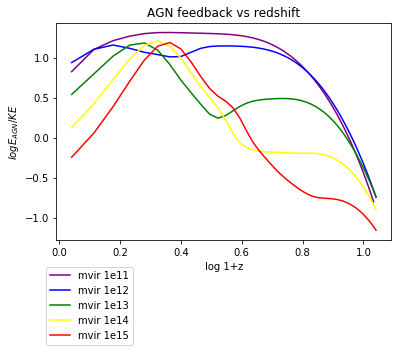

In [21]:
z0 = 0.1
z = np.linspace(0.1, 10, 50)
Mvir = [1e11,1e12,1e13,1e14,1e15,]


Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])


AGN_f1=[]
AGN_f2=[]
AGN_f3=[]
AGN_f4=[]
AGN_f5=[]


for i in range(0, 50):
    redshift = z[i]
    m_v1 = halo_mass_assembly(Mvir[0], z0, redshift)
    m_v2 = halo_mass_assembly(Mvir[1], z0, redshift)
    m_v3 = halo_mass_assembly(Mvir[2], z0, redshift)
    m_v4 = halo_mass_assembly(Mvir[3], z0, redshift)
    m_v5 = halo_mass_assembly(Mvir[4], z0, redshift)
    m_s1 = SHMR(redshift,m_v1)
    m_s2 = SHMR(redshift,m_v2)
    m_s3 = SHMR(redshift,m_v3)
    m_s4 = SHMR(redshift,m_v4)
    m_s5 = SHMR(redshift,m_v5)
    reff_all1 = avg_rad_eff(m_s1, redshift)
    reff_all2 = avg_rad_eff(m_s2, redshift)
    reff_all3 = avg_rad_eff(m_s3, redshift)
    reff_all4 = avg_rad_eff(m_s4, redshift)
    reff_all5 = avg_rad_eff(m_s5, redshift)
    AGN_f1.append(AGN_feedback(m_v1, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f2.append(AGN_feedback(m_v2, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f3.append(AGN_feedback(m_v3, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f4.append(AGN_feedback(m_v4, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f5.append(AGN_feedback(m_v5, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))



    

plt.title('AGN feedback vs redshift')
plt.plot(np.log10(1+z), np.log10(AGN_f1), '-k', color='purple', label='mvir 1e11')
plt.plot(np.log10(1+z), np.log10(AGN_f2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+z), np.log10(AGN_f3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+z), np.log10(AGN_f4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+z), np.log10(AGN_f5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('$log E_{AGN}/KE$')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/AGN_feedback_Z.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


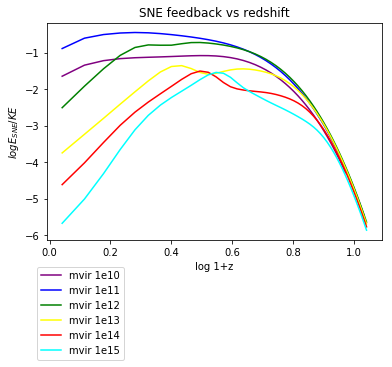

In [17]:
z0 = 0.1
z = np.linspace(0.1, 10, 50)
Mvir = [1e10,1e11,1e12,1e13,1e14,1e15]


Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])
Ms6 = SHMR(z,Mvir[5])


SNE_f1=[]
SNE_f2=[]
SNE_f3=[]
SNE_f4=[]
SNE_f5=[]
SNE_f6=[]


for i in range(0, 50):
    redshift = z[i]
    m_v1 = halo_mass_assembly(Mvir[0], z0, redshift)
    m_v2 = halo_mass_assembly(Mvir[1], z0, redshift)
    m_v3 = halo_mass_assembly(Mvir[2], z0, redshift)
    m_v4 = halo_mass_assembly(Mvir[3], z0, redshift)
    m_v5 = halo_mass_assembly(Mvir[4], z0, redshift)
    m_v6 = halo_mass_assembly(Mvir[5], z0, redshift)
    m_s1 = SHMR(redshift,m_v1)
    m_s2 = SHMR(redshift,m_v2)
    m_s3 = SHMR(redshift,m_v3)
    m_s4 = SHMR(redshift,m_v4)
    m_s5 = SHMR(redshift,m_v5)
    m_s6 = SHMR(redshift,m_v6)
    reff_all1 = avg_rad_eff(m_s1, redshift)
    reff_all2 = avg_rad_eff(m_s2, redshift)
    reff_all3 = avg_rad_eff(m_s3, redshift)
    reff_all4 = avg_rad_eff(m_s4, redshift)
    reff_all5 = avg_rad_eff(m_s5, redshift)
    reff_all6 = avg_rad_eff(m_s6, redshift)
    SNE_f1.append(SNE_feedback(m_v1, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f2.append(SNE_feedback(m_v2, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f3.append(SNE_feedback(m_v3, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f4.append(SNE_feedback(m_v4, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f5.append(SNE_feedback(m_v5, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f6.append(SNE_feedback(m_v6, m_s6, reff_all6,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))


    

plt.title('SNE feedback vs redshift')
plt.plot(np.log10(1+z), np.log10(SNE_f1), '-k', color='purple', label='mvir 1e10')
plt.plot(np.log10(1+z), np.log10(SNE_f2), '-k', color='blue', label='mvir 1e11')
plt.plot(np.log10(1+z), np.log10(SNE_f3), '-k', color='green', label='mvir 1e12')
plt.plot(np.log10(1+z), np.log10(SNE_f4), '-k', color='yellow', label='mvir 1e13')
plt.plot(np.log10(1+z), np.log10(SNE_f5), '-k', color='red', label='mvir 1e14')
plt.plot(np.log10(1+z), np.log10(SNE_f6), '-k', color='aqua', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('$log E_{SNE}/KE$')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/SNE_feedback_Z.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


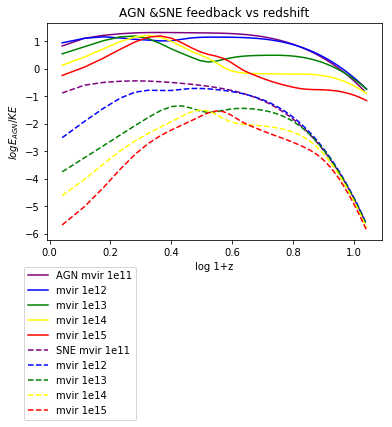

In [27]:
z0 = 0.1
z = np.linspace(0.1, 10, 50)
Mvir = [1e11,1e12,1e13,1e14,1e15]


Ms1 = SHMR(z,Mvir[0])
Ms2 = SHMR(z,Mvir[1])
Ms3 = SHMR(z,Mvir[2])
Ms4 = SHMR(z,Mvir[3])
Ms5 = SHMR(z,Mvir[4])


AGN_f1=[]
AGN_f2=[]
AGN_f3=[]
AGN_f4=[]
AGN_f5=[]

SNE_f1=[]
SNE_f2=[]
SNE_f3=[]
SNE_f4=[]
SNE_f5=[]


for i in range(0, 50):
    redshift = z[i]
    m_v1 = halo_mass_assembly(Mvir[0], z0, redshift)
    m_v2 = halo_mass_assembly(Mvir[1], z0, redshift)
    m_v3 = halo_mass_assembly(Mvir[2], z0, redshift)
    m_v4 = halo_mass_assembly(Mvir[3], z0, redshift)
    m_v5 = halo_mass_assembly(Mvir[4], z0, redshift)
    m_s1 = SHMR(redshift,m_v1)
    m_s2 = SHMR(redshift,m_v2)
    m_s3 = SHMR(redshift,m_v3)
    m_s4 = SHMR(redshift,m_v4)
    m_s5 = SHMR(redshift,m_v5)
    reff_all1 = avg_rad_eff(m_s1, redshift)
    reff_all2 = avg_rad_eff(m_s2, redshift)
    reff_all3 = avg_rad_eff(m_s3, redshift)
    reff_all4 = avg_rad_eff(m_s4, redshift)
    reff_all5 = avg_rad_eff(m_s5, redshift)
    AGN_f1.append(AGN_feedback(m_v1, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f2.append(AGN_feedback(m_v2, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f3.append(AGN_feedback(m_v3, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f4.append(AGN_feedback(m_v4, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f5.append(AGN_feedback(m_v5, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f1.append(SNE_feedback(m_v1, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f2.append(SNE_feedback(m_v2, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f3.append(SNE_feedback(m_v3, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f4.append(SNE_feedback(m_v4, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f5.append(SNE_feedback(m_v5, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    



    

plt.title('AGN &SNE feedback vs redshift')
plt.plot(np.log10(1+z), np.log10(AGN_f1), '-k', color='purple', label='AGN mvir 1e11')
plt.plot(np.log10(1+z), np.log10(AGN_f2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+z), np.log10(AGN_f3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+z), np.log10(AGN_f4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+z), np.log10(AGN_f5), '-k', color='red', label='mvir 1e15')
plt.plot(np.log10(1+z), np.log10(SNE_f1), '--k', color='purple', label='SNE mvir 1e11')
plt.plot(np.log10(1+z), np.log10(SNE_f2), '--k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+z), np.log10(SNE_f3), '--k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+z), np.log10(SNE_f4), '--k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+z), np.log10(SNE_f5), '--k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('$log E_{AGN}/KE$')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/AGN_SNE_feedback_Z.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()